In [1]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from numpy import argmax
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from tqdm import tqdm
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV
import collections
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import pandas as pd

In [2]:
import numpy as np

In [3]:
human_lombardo = pd.read_csv("../data/human_smiles_r_v3.csv")
human_lombardo = human_lombardo[human_lombardo["smiles_r"]!="Cannot_do"].reset_index(drop=True)

In [4]:
human_lombardo=  human_lombardo[[ "smiles_r","human_VDss_L_kg","human_CL_mL_min_kg", "human_fup", "human_mrt", "human_thalf"]]

for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg", "human_mrt", "human_thalf" ]:
    print("Transformed endpoint to log base 10")
    human_lombardo[endpoint] = np.log10(human_lombardo[endpoint])
human_lombardo

Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10


smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  
0               0.638489       0.33   0.568202     1.176091  
1               0.949390        NaN   1.348305     1.705008  
2              -0.537602       0.01   1.482588     1.894870  
3               1.301030       0.13   0.204120     0.113943  
4               0.204120        NaN   1.068186     1.037426  
...                  ...        ...        ...          ...  
1278            0.903090        NaN   1.021189     0.913814  
1279            0.707570       0.35   1.361728     1.204120  
1280            0.934498       0.50   0.892095     0.863323  
1281            1.293804        NaN   0.537819     0.359835  
1282            1.000000        NaN   0.740363     0.623249  

[1283 rows x 6 columns]

In [5]:
human_lombardo = human_lombardo.groupby('smiles_r').median().reset_index()
human_lombardo

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  
0               0.638489       0.33   0.568202     1.176091  
1               0.949390        NaN   1.348305     1.705008  
2              -0.537602       0.01   1.482588     1.894870  
3               1.301030       0.13   0.204120     0.113943  
4               0.204120        NaN   1.068186     1.037426  
...                  ...        ...        ...          ...  
1278            0.903090        NaN   1.021189     0.913814  
1279            0.707570       0.35   1.361728     1.204120  
1280            0.934498       0.50   0.892095     0.863323  
1281            1.293804        NaN   0.537819     0.359835  
1282            1.000000        NaN   0.740363     0.623249  

[1283 rows x 6 columns]

In [6]:
human_smiles_r = human_lombardo[["smiles_r"]]
human_smiles_r

smiles_r
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...
3                             C#CC[NH+](C)C(C)Cc1ccccc1
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...
...                                                 ...
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2

[1283 rows x 1 columns]

In [7]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress
    
def count(pred, true, min, max, endpoint):

    if(endpoint == "human_fup"):
        lst = [abs(a/b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    else:
        lst = [abs(10**a/10**b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    return

def calc_gmfe(pred, true, endpoint):
    
    if(endpoint == "human_fup"):
        
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        return (10**mean_abs)
    
    else: 
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        
        return (10** mean_abs)
    
    return
                         
def median_fold_change_error(pred, true, endpoint):
                         
    if (endpoint == "human_fup"):
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    else:
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    return
                          
def calc_bias(pred, true, endpoint):
                          
    if (endpoint == "human_fup"):
        lst = [(a - b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    else:
        lst = [(10**a - 10**b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    return

In [8]:
from rdkit import Chem
from mordred import Calculator, descriptors

# create descriptor calculator with all descriptors
calc = Calculator(descriptors, ignore_3D=False)

print(len(calc.descriptors))

Ser_Mol = human_lombardo['smiles_r'].apply(Chem.MolFromSmiles)

# as pandas
Mordred_table=  calc.pandas(Ser_Mol)

1826


  1%|▌                                        | 18/1283 [00:01<01:58, 10.67it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 19%|███████▌                               | 248/1283 [00:02<00:05, 181.21it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, ax

 23%|████████▉                              | 292/1283 [00:03<00:07, 138.85it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 28%|██████████▉                            | 359/1283 [00:03<00:05, 160.51it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 32%|████████████▎                          | 407/1283 [00:04<00:07, 112.75it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 46%|█████████████████▉                     | 590/1283 [00:04<00:02, 256.11it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, ax

 48%|██████████████████▊                    | 619/1283 [00:04<00:03, 203.72it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 64%|█████████████████████████              | 824/1283 [00:05<00:01, 285.06it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 69%|███████████████████████████            | 889/1283 [00:06<00:02, 138.49it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 80%|██████████████████████████████▎       | 1023/1283 [00:07<00:01, 214.20it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████████████████████████████████| 1283/1283 [00:08<00:00, 155.73it/s]


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [9]:
Mordred_table = Mordred_table.astype('float')
Mordred_table['smiles_r'] = human_lombardo['smiles_r']
Mordred_table

ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0     26.726479  20.199330    2.0    0.0  43.712035  2.420516  4.841033   
1     16.484101  15.092007    1.0    0.0  24.810570  2.476291  4.952581   
2     30.181133  23.132813    4.0    0.0  49.053928  2.449016  4.898018   
3     10.077834   9.321842    0.0    1.0  17.214150  2.226811  4.453621   
4     14.384684  13.322169    0.0    0.0  23.623048  2.530742  4.897943   
...         ...        ...    ...    ...        ...       ...       ...   
1278  12.606602  10.129166    0.0    1.0  22.084432  2.412947  4.825894   
1279  14.018917  11.675935    0.0    1.0  24.741115  2.478172  4.956344   
1280  16.038187  14.420804    0.0    2.0  27.701443  2.658726  5.024986   
1281  15.515909  12.987974    0.0    2.0  26.938755  2.326623  4.635214   
1282  11.939935   9.906091    0.0    2.0  20.559285  2.387450  4.754235   

         SpAD_A   SpMAD_A   LogEE_A  ...     TSRW10          MW       AMW  \
0     43.712035  1.248915  4.459804  ...  71.132315  475.161514  8.485027   
1     24.810570  1.127753  3.981521  ...  56.111877  299.201654  6.106156   
2     49.053928  1.257793  4.581296  ...  89.010877  529.176450  8.675024   
3     17.214150  1.229582  3.514311  ...  44.372474  188.143376  5.879480   
4     23.623048  1.243318  3.870813  ...  67.418049  267.085521  8.346423   
...         ...       ...       ...  ...        ...         ...       ...   
1278  22.084432  1.380277  3.723828  ...  48.647579  221.128454  6.700862   
1279  24.741115  1.374506  3.833767  ...  51.418286  244.205976  5.550136   
1280  27.701443  1.385072  3.997563  ...  75.593926  263.154275  6.747546   
1281  26.938755  1.346938  3.923960  ...  66.060685  266.165174  6.654129   
1282  20.559285  1.370619  3.669040  ...  60.402256  205.097154  7.324898   

       WPath  WPol  Zagreb1  Zagreb2   mZagreb1  mZagreb2  \
0     4344.0  54.0    176.0    202.0  13.083333  7.805556   
1     1036.0  34.0    110.0    125.0  11.180556  4.750000   
2     5657.0  62.0    202.0    236.0  13.805556  8.611111   
3      337.0  16.0     62.0     67.0   5.333333  3.361111   
4      654.0  34.0    100.0    122.0   8.229167  4.291667   
...      ...   ...      ...      ...        ...       ...   
1278   412.0  24.0     84.0     99.0   3.444444  3.583333   
1279   549.0  29.0     94.0    112.0   4.034722  4.083333   
1280   751.0  30.0    112.0    139.0   4.256944  4.402778   
1281   829.0  24.0    100.0    113.0   4.444444  4.527778   
1282   359.0  20.0     80.0     94.0   3.194444  3.305556   

                                               smiles_r  
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...  
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1  
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...  
3                             C#CC[NH+](C)C(C)Cc1ccccc1  
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...  
...                                                 ...  
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2  
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1  
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1  
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1  
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2  

[1283 rows x 1827 columns]

In [10]:
len(Mordred_table.columns[Mordred_table.isna().any()].tolist())

654

In [11]:
Ser_Mol = human_lombardo['smiles_r'].apply(Chem.MolFromSmiles)

import numpy as np
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

Morgan_fingerprint= Ser_Mol.apply(GetMorganFingerprintAsBitVect, args=(2, 2048))
Morganfingerprint_array  = np.stack(Morgan_fingerprint)

Morgan_collection  = []
for x in np.arange(Morganfingerprint_array.shape[1]): #np.arange plus rapide que range
    x = "Mfp"+str(x)
    Morgan_collection.append(x)

Morganfingerprint_table  = pd.DataFrame(Morganfingerprint_array , columns=Morgan_collection )
Morganfingerprint_table['smiles_r'] = human_lombardo['smiles_r']
Morganfingerprint_table

Mfp0  Mfp1  Mfp2  Mfp3  Mfp4  Mfp5  Mfp6  Mfp7  Mfp8  Mfp9  ...  \
0        0     1     0     0     0     0     0     0     0     0  ...   
1        0     0     0     0     0     0     0     0     0     0  ...   
2        0     1     0     0     0     0     0     0     0     0  ...   
3        0     1     0     0     1     0     0     0     0     0  ...   
4        0     0     0     0     0     0     0     0     0     0  ...   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
1278     0     0     0     0     0     0     0     0     0     0  ...   
1279     0     0     1     0     0     0     0     0     0     0  ...   
1280     0     0     0     0     0     0     0     0     0     0  ...   
1281     0     0     0     0     0     0     0     0     0     0  ...   
1282     0     0     0     0     0     0     0     0     0     0  ...   

      Mfp2039  Mfp2040  Mfp2041  Mfp2042  Mfp2043  Mfp2044  Mfp2045  Mfp2046  \
0           0        0        0        0        0        0        0        0   
1           0        0        0        0        0        0        0        0   
2           0        0        0        0        0        0        0        0   
3           0        0        0        0        0        0        0        0   
4           0        0        0        1        0        0        0        0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
1278        0        0        0        0        0        0        0        0   
1279        0        0        0        0        0        0        0        0   
1280        0        0        0        0        0        0        0        0   
1281        0        0        0        0        0        0        0        0   
1282        0        0        0        0        0        0        0        0   

      Mfp2047                                           smiles_r  
0           0  C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...  
1           0      C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1  
2           0  C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...  
3           0                          C#CC[NH+](C)C(C)Cc1ccccc1  
4           0  C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...  
...       ...                                                ...  
1278        0                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2  
1279        0                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1  
1280        0              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1  
1281        0                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1  
1282        0                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2  

[1283 rows x 2049 columns]

In [12]:
human_lombardo_mfp = pd.merge(human_lombardo, Morganfingerprint_table)
human_lombardo_mfp_Mordred = pd.merge(human_lombardo_mfp, Mordred_table)
human_lombardo_mfp_Mordred

#human_lombardo_mfp = pd.merge(human_lombardo, Morganfingerprint_table)
#human_lombardo_mfp_Mordred = pd.merge(human_lombardo_mfp, Mordred_table)
#human_lombardo_mfp_Mordred

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  Mfp0  Mfp1  Mfp2  \
0               0.638489       0.33   0.568202     1.176091     0     1     0   
1               0.949390        NaN   1.348305     1.705008     0     0     0   
2              -0.537602       0.01   1.482588     1.894870     0     1     0   
3               1.301030       0.13   0.204120     0.113943     0     1     0   
4               0.204120        NaN   1.068186     1.037426     0     0     0   
...                  ...        ...        ...          ...   ...   ...   ...   
1278            0.903090        NaN   1.021189     0.913814     0     0     0   
1279            0.707570       0.35   1.361728     1.204120     0     0     1   
1280            0.934498       0.50   0.892095     0.863323     0     0     0   
1281            1.293804        NaN   0.537819     0.359835     0     0     0   
1282            1.000000        NaN   0.740363     0.623249     0     0     0   

      Mfp3  ...      SRW10     TSRW10          MW       AMW   WPath  WPol  \
0        0  ...  10.345445  71.132315  475.161514  8.485027  4344.0  54.0   
1        0  ...  10.048237  56.111877  299.201654  6.106156  1036.0  34.0   
2        0  ...  10.533295  89.010877  529.176450  8.675024  5657.0  62.0   
3        0  ...   8.987072  44.372474  188.143376  5.879480   337.0  16.0   
4        0  ...  10.060961  67.418049  267.085521  8.346423   654.0  34.0   
...    ...  ...        ...        ...         ...       ...     ...   ...   
1278     0  ...   9.706073  48.647579  221.128454  6.700862   412.0  24.0   
1279     0  ...   9.934065  51.418286  244.205976  5.550136   549.0  29.0   
1280     0  ...  10.245906  75.593926  263.154275  6.747546   751.0  30.0   
1281     0  ...   9.582249  66.060685  266.165174  6.654129   829.0  24.0   
1282     0  ...   9.585003  60.402256  205.097154  7.324898   359.0  20.0   

      Zagreb1  Zagreb2   mZagreb1  mZagreb2  
0       176.0    202.0  13.083333  7.805556  
1       110.0    125.0  11.180556  4.750000  
2       202.0    236.0  13.805556  8.611111  
3        62.0     67.0   5.333333  3.361111  
4       100.0    122.0   8.229167  4.291667  
...       ...      ...        ...       ...  
1278     84.0     99.0   3.444444  3.583333  
1279     94.0    112.0   4.034722  4.083333  
1280    112.0    139.0   4.256944  4.402778  
1281    100.0    113.0   4.444444  4.527778  
1282     80.0     94.0   3.194444  3.305556  

[1283 rows x 3880 columns]

In [13]:
animal = pd.read_csv("../data/animal_smiles_r.csv")
animal = animal[animal["smiles_r"]!="Cannot_do"].reset_index(drop=True)
animal = animal[["InChICode_standardised",  "smiles_r", "rat_VDss_L_kg", "rat_CL_mL_min_kg", "rat_fup", 
                 "dog_VDss_L_kg" , "dog_CL_mL_min_kg", "dog_fup",
                 "monkey_VDss_L_kg", "monkey_CL_mL_min_kg", "monkey_fup"]]


for endpoint in ["rat_VDss_L_kg", "rat_CL_mL_min_kg", 
                 "dog_VDss_L_kg" , "dog_CL_mL_min_kg", 
                 "monkey_VDss_L_kg", "monkey_CL_mL_min_kg"]:
    print("Transformed endpoint to log base 10")
    animal[endpoint] = np.log10(animal[endpoint])
animal

Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10


InChICode_standardised  \
0    InChI=1S/C4H3FN2O2/c5-2-1-6-4(9)7-3(2)8/h1H,(H...   
1    InChI=1S/C5H4N4S/c10-5-3-4(7-1-6-3)8-2-9-5/h1-...   
2    InChI=1S/C28H26N4O4/c1-28-25(35-3)15(29-2)12-1...   
3    InChI=1S/C20H17N3O4/c1-2-20(26)13-7-16-17-10(6...   
4    InChI=1S/C14H18N6O/c15-14-18-12(17-9-2-3-9)11-...   
..                                                 ...   
394  InChI=1S/C10H13N5O4/c1-5-3-15(10(18)12-9(5)17)...   
395  InChI=1S/C70H97Cl2NO38/c1-24-15-31(74)16-32(75...   
396  InChI=1S/C5H8N2O7P2/c8-5(15(9,10)11,16(12,13)1...   
397  InChI=1S/C16H21N3O2/c1-19(2)6-5-12-9-17-15-4-3...   
398  InChI=1S/C19H21N3O/c1-13-5-8-15(9-6-13)19-16(1...   

                                              smiles_r  rat_VDss_L_kg  \
0                              O=c1[nH]cc(F)c(=O)[nH]1      -0.602060   
1                                S=c1[nH]cnc2[nH]cnc12            NaN   
2    CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...       1.222716   
3    CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(N)cccc...       0.698970   
4        Nc1nc(NC2CC2)c2ncn([C@H]3C=C[C@@H](CO)C3)c2n1            NaN   
..                                                 ...            ...   
394  Cc1cn([C@H]2C[C@H](N=[N+]=[N-])[C@@H](CO)O2)c(...      -0.065502   
395  COC[C@H]1O[C@@H](O[C@@H]2OC[C@@H]3O[C@@]4(OC[C...            NaN   
396           O=[PH](=O)(O)C(O)(Cn1ccnc1)[PH](=O)(=O)O            NaN   
397          CN(C)CCc1c[nH]c2ccc(C[C@H]3COC(=O)N3)cc12       0.547775   
398            Cc1ccc(-c2nc3ccc(C)cn3c2CC(=O)N(C)C)cc1       0.021189   

     rat_CL_mL_min_kg  rat_fup  dog_VDss_L_kg  dog_CL_mL_min_kg  dog_fup  \
0            1.518514    0.690            NaN               NaN      NaN   
1                 NaN      NaN            NaN               NaN      NaN   
2            1.812913      NaN       0.784617          1.008600   0.0074   
3            2.176091      NaN            NaN               NaN      NaN   
4            1.477121      NaN            NaN               NaN      NaN   
..                ...      ...            ...               ...      ...   
394          1.399674    0.687       0.000000          1.146128   0.8270   
395               NaN      NaN            NaN               NaN      NaN   
396               NaN      NaN      -0.552842          0.615950      NaN   
397          1.468347      NaN            NaN               NaN      NaN   
398          1.687529    0.170            NaN               NaN      NaN   

     monkey_VDss_L_kg  monkey_CL_mL_min_kg  monkey_fup  
0                 NaN                  NaN         NaN  
1           -0.045757             1.181844         NaN  
2                 NaN                  NaN         NaN  
3                 NaN                  NaN         NaN  
4                 NaN                  NaN         NaN  
..                ...                  ...         ...  
394               NaN                  NaN       0.707  
395         -0.657577             1.220108         NaN  
396               NaN                  NaN         NaN  
397               NaN                  NaN         NaN  
398               NaN                  NaN         NaN  

[399 rows x 11 columns]

In [14]:
human_lombardo_mfp_Mordred_animal = human_lombardo_mfp_Mordred.merge(animal, how="left", on="smiles_r")
human_lombardo_mfp_Mordred_animal

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  Mfp0  Mfp1  Mfp2  \
0               0.638489       0.33   0.568202     1.176091     0     1     0   
1               0.949390        NaN   1.348305     1.705008     0     0     0   
2              -0.537602       0.01   1.482588     1.894870     0     1     0   
3               1.301030       0.13   0.204120     0.113943     0     1     0   
4               0.204120        NaN   1.068186     1.037426     0     0     0   
...                  ...        ...        ...          ...   ...   ...   ...   
1278            0.903090        NaN   1.021189     0.913814     0     0     0   
1279            0.707570       0.35   1.361728     1.204120     0     0     1   
1280            0.934498       0.50   0.892095     0.863323     0     0     0   
1281            1.293804        NaN   0.537819     0.359835     0     0     0   
1282            1.000000        NaN   0.740363     0.623249     0     0     0   

      Mfp3  ...  InChICode_standardised  rat_VDss_L_kg  rat_CL_mL_min_kg  \
0        0  ...                     NaN            NaN               NaN   
1        0  ...                     NaN            NaN               NaN   
2        0  ...                     NaN            NaN               NaN   
3        0  ...                     NaN            NaN               NaN   
4        0  ...                     NaN            NaN               NaN   
...    ...  ...                     ...            ...               ...   
1278     0  ...                     NaN            NaN               NaN   
1279     0  ...                     NaN            NaN               NaN   
1280     0  ...                     NaN            NaN               NaN   
1281     0  ...                     NaN            NaN               NaN   
1282     0  ...                     NaN            NaN               NaN   

      rat_fup  dog_VDss_L_kg  dog_CL_mL_min_kg  dog_fup  monkey_VDss_L_kg  \
0         NaN            NaN               NaN      NaN               NaN   
1         NaN            NaN               NaN      NaN               NaN   
2         NaN            NaN               NaN      NaN               NaN   
3         NaN            NaN               NaN      NaN               NaN   
4         NaN            NaN               NaN      NaN               NaN   
...       ...            ...               ...      ...               ...   
1278      NaN            NaN               NaN      NaN               NaN   
1279      NaN            NaN               NaN      NaN               NaN   
1280      NaN            NaN               NaN      NaN               NaN   
1281      NaN            NaN               NaN      NaN               NaN   
1282      NaN            NaN               NaN      NaN               NaN   

      monkey_CL_mL_min_kg  monkey_fup  
0                     NaN         NaN  
1                     NaN         NaN  
2                     NaN         NaN  
3                     NaN         NaN  
4                     NaN         NaN  
...                   ...         ...  
1278                  NaN         NaN  
127

In [15]:
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def predict_animal(data, test_index, endpoint, animal):#log human_VDss_L_kg model
    
    #Read columns needed for rat data
    file = open(f"features_mfp_mordred_columns_{animal}_model.txt", "r")
    file_lines = file.read()
    features = file_lines.split("\n")
    features = features[:-1]

    loaded_rf = pickle.load(open(f"log_{endpoint}_model.sav", 'rb'))

    X_test=data.iloc[test_index][features]
    
    imp=SimpleImputer(missing_values=np.nan, strategy='median')
    X_new=pd.DataFrame(imp.fit_transform(X_test))
    X_new.columns=X_test.columns
    X_new.index=X_test.index

    # Load the scaler from the file
    with open(f'scaler_{animal}.pkl', 'rb') as file:
        scaler = pickle.load(file)

    # Scale the features using the loaded scaler
    X_new = scaler.transform(X_new)
    X_new = pd.DataFrame(X_new, columns=features)
    
    y_pred =  loaded_rf.predict(X_new)     
   
    print(len(y_pred))
    return(y_pred)

In [16]:
endpoints = ["dog_VDss_L_kg","dog_CL_mL_min_kg","dog_fup"]

for endpoint in endpoints:
    
    print(endpoint)
    test_index = human_lombardo_mfp_Mordred_animal.loc[pd.isna(human_lombardo_mfp_Mordred_animal[endpoint]), :].index.values
    
    
    preds = predict_animal(human_lombardo_mfp_Mordred_animal,test_index, endpoint, "dog") 
    
        
    #imputing dataframe with rat values
    for i, j  in enumerate(preds):
        human_lombardo_mfp_Mordred_animal.loc[test_index[i], endpoint] = preds[i]

dog_VDss_L_kg
1252
dog_CL_mL_min_kg


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


1251
dog_fup
1262


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [17]:
endpoints = ["monkey_VDss_L_kg","monkey_CL_mL_min_kg","monkey_fup"]

for endpoint in endpoints:
    
    print(endpoint)
    test_index = human_lombardo_mfp_Mordred_animal.loc[pd.isna(human_lombardo_mfp_Mordred_animal[endpoint]), :].index.values
    
    
    preds = predict_animal(human_lombardo_mfp_Mordred_animal,test_index, endpoint, "monkey") 
    
        
    #imputing dataframe with rat values
    for i, j  in enumerate(preds):
        human_lombardo_mfp_Mordred_animal.loc[test_index[i], endpoint] = preds[i]

monkey_VDss_L_kg
1270
monkey_CL_mL_min_kg


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


1270
monkey_fup
1277


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [18]:
endpoints = ["rat_VDss_L_kg","rat_CL_mL_min_kg","rat_fup"]

for endpoint in endpoints:
    
    print(endpoint)
    test_index = human_lombardo_mfp_Mordred_animal.loc[pd.isna(human_lombardo_mfp_Mordred_animal[endpoint]), :].index.values
    
    
    preds = predict_animal(human_lombardo_mfp_Mordred_animal,test_index, endpoint, "rat") 
    
        
    #imputing dataframe with rat values
    for i, j  in enumerate(preds):
        human_lombardo_mfp_Mordred_animal.loc[test_index[i], endpoint] = preds[i]

rat_VDss_L_kg
1240
rat_CL_mL_min_kg
1239


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


rat_fup
1254


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [19]:
human_lombardo_mfp_Mordred_animal

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  Mfp0  Mfp1  Mfp2  \
0               0.638489       0.33   0.568202     1.176091     0     1     0   
1               0.949390        NaN   1.348305     1.705008     0     0     0   
2              -0.537602       0.01   1.482588     1.894870     0     1     0   
3               1.301030       0.13   0.204120     0.113943     0     1     0   
4               0.204120        NaN   1.068186     1.037426     0     0     0   
...                  ...        ...        ...          ...   ...   ...   ...   
1278            0.903090        NaN   1.021189     0.913814     0     0     0   
1279            0.707570       0.35   1.361728     1.204120     0     0     1   
1280            0.934498       0.50   0.892095     0.863323     0     0     0   
1281            1.293804        NaN   0.537819     0.359835     0     0     0   
1282            1.000000        NaN   0.740363     0.623249     0     0     0   

      Mfp3  ...  InChICode_standardised  rat_VDss_L_kg  rat_CL_mL_min_kg  \
0        0  ...                     NaN      -0.290548          1.036835   
1        0  ...                     NaN       0.756028          1.584792   
2        0  ...                     NaN      -0.211381          0.995492   
3        0  ...                     NaN       0.672094          1.801053   
4        0  ...                     NaN       0.324036          1.282031   
...    ...  ...                     ...            ...               ...   
1278     0  ...                     NaN       0.537981          1.669147   
1279     0  ...                     NaN       0.909628          1.798600   
1280     0  ...                     NaN       0.707936          1.458739   
1281     0  ...                     NaN       0.682568          1.596347   
1282     0  ...                     NaN       0.434450          1.799098   

       rat_fup  dog_VDss_L_kg  dog_CL_mL_min_kg   dog_fup  monkey_VDss_L_kg  \
0     0.359284      -0.158726          0.362066  0.499177         -0.369579   
1     0.253218       0.918734          1.452824  0.276782          0.144653   
2     0.294808      -0.079764          0.733717  0.405260         -0.349402   
3     0.310000       0.709190          1.853286  0.451163          0.434232   
4     0.760450       0.027014          0.865836  0.804895          0.523202   
...        ...            ...               ...       ...               ...   
1278  0.519962       0.256945          1.256928  0.582045          0.297234   
1279  0.370000       0.837022          1.692485  0.430189          0.684847   
1280  0.291611       0.523326          1.460848  0.275646          0.299982   
1281  0.356636       0.444367          1.396392  0.234548          0.368539   
1282  0.591757       0.168576          1.196207  0.640606          0.196214   

      monkey_CL_mL_min_kg  monkey_fup  
0                0.849437    0.325943  
1                1.188360    0.315889  
2                0.682315    0.267692  
3                1.155119    0.464263  
4                1.289234    0.635759  
...                   ...         ...  
1278             1.

In [20]:
animal_columns = ["dog_VDss_L_kg","dog_CL_mL_min_kg","dog_fup","monkey_VDss_L_kg","monkey_CL_mL_min_kg","monkey_fup", "rat_VDss_L_kg","rat_CL_mL_min_kg","rat_fup"]

file = open("features_mfp_mordred_columns_human.txt", "r")
file_lines = file.read()
features_mfp_mordred_columns = file_lines.split("\n")
features_mfp_mordred_columns = features_mfp_mordred_columns[:-1]

In [21]:
features_mfp_mordred_animal_columns = features_mfp_mordred_columns + animal_columns
print(len(features_mfp_mordred_animal_columns))

513


In [22]:
#Write to file
#len(features_mfp_mordred_columns)
f = open("features_mfp_mordred_animal_artificial_and_real_human_modelcolumns.txt", "w")
for item in features_mfp_mordred_animal_columns:
   f.write(item + "\n")
f.close()

human_VDss_L_kg
0
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=42)
Calculating Permutation Importances
250
2-fold :  56.8
3-fold :  74.4
5-fold :  87.6
gmfe :  2.1478374878402398
mfe :  1.3045314406307453
bias :  0.04542339730099437
rmse  0.44314955565529013
r2  0.5448507357049883
saving model


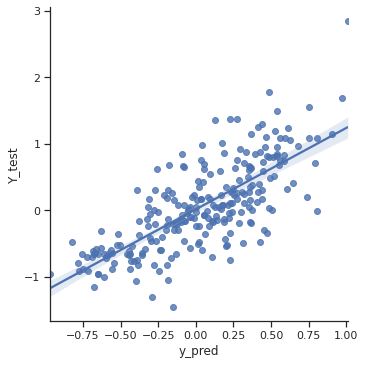

1
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=42)
Calculating Permutation Importances
250
2-fold :  58.4
3-fold :  75.6
5-fold :  90.0
gmfe :  2.069259606367862
mfe :  1.2882373412139463
bias :  0.1055537968136015
rmse  0.40998316998666917
r2  0.5497808882063869
saving model


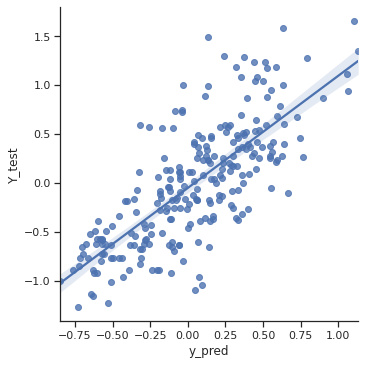

2
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
250
2-fold :  57.199999999999996
3-fold :  73.6
5-fold :  86.4
gmfe :  2.20540827548987
mfe :  1.265573919961376
bias :  -0.0029618762148944378
rmse  0.4757858052924401
r2  0.4788568435479784


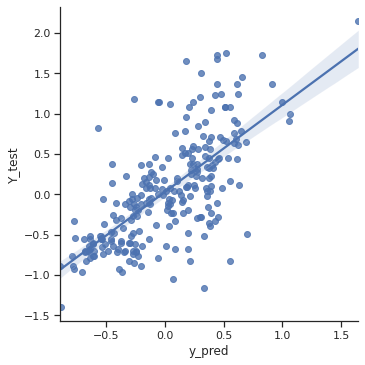

3
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
250
2-fold :  60.4
3-fold :  74.8
5-fold :  89.60000000000001
gmfe :  2.0778747913714364
mfe :  1.2815882595564576
bias :  -0.0012140348440711907
rmse  0.4196409967938262
r2  0.5795175041765224


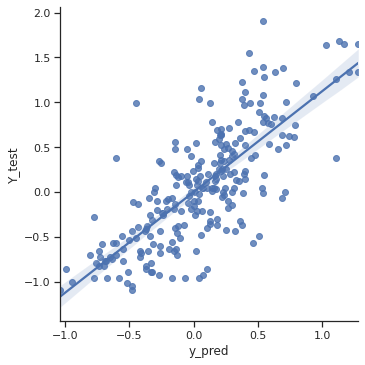

4
(1000, 513)
(249, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=42)
Calculating Permutation Importances
249
2-fold :  53.81526104417671
3-fold :  74.29718875502009
5-fold :  90.76305220883533
gmfe :  2.18505838619049
mfe :  1.316642711743605
bias :  0.05047501186556791
rmse  0.4453949361978406
r2  0.4858371284262728


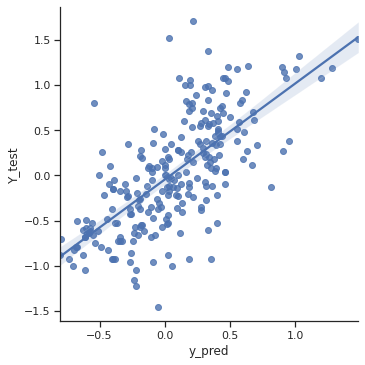

0
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
250
2-fold :  59.599999999999994
3-fold :  72.39999999999999
5-fold :  87.2
gmfe :  2.13720309001467
mfe :  1.2739816549847898
bias :  0.036903023450147426
rmse  0.4316107715056925
r2  0.49001524459551216


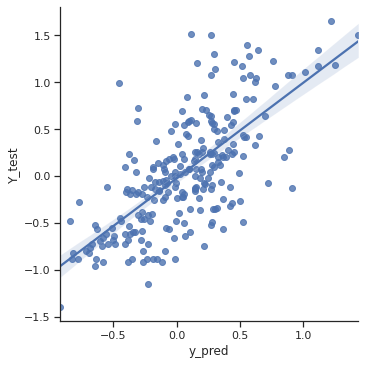

1
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
Calculating Permutation Importances
250
2-fold :  53.6
3-fold :  73.2
5-fold :  86.8
gmfe :  2.2691786434655343
mfe :  1.3124865249913906
bias :  0.0410574770420916
rmse  0.4692917853216799
r2  0.5211146212773107


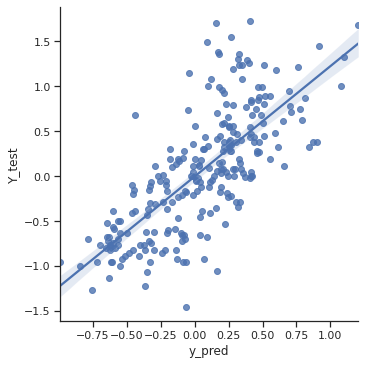

2
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
250
2-fold :  60.0
3-fold :  78.4
5-fold :  89.60000000000001
gmfe :  2.082535351257978
mfe :  1.2682409561507977
bias :  0.018454230380938158
rmse  0.43441831361772415
r2  0.5194814411873655


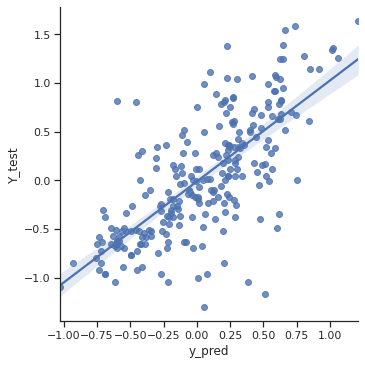

3
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
250
2-fold :  60.8
3-fold :  77.2
5-fold :  92.4
gmfe :  2.0258902672487777
mfe :  1.2521934778947221
bias :  0.014806146114972309
rmse  0.4207207134023837
r2  0.5636551310776896
saving model


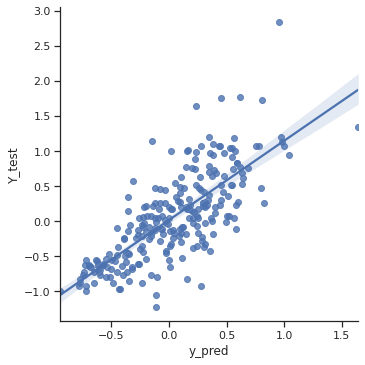

4
(1000, 513)
(249, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
Calculating Permutation Importances
249
2-fold :  55.82329317269076
3-fold :  74.69879518072288
5-fold :  90.76305220883533
gmfe :  2.11733627625788
mfe :  1.280793707241678
bias :  0.022048039256077123
rmse  0.43674151183440396
r2  0.546722482536498


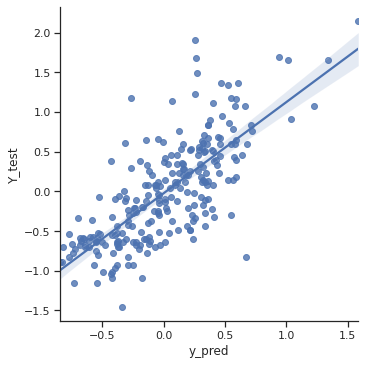

0
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=44)
Calculating Permutation Importances
250
2-fold :  56.39999999999999
3-fold :  74.0
5-fold :  86.4
gmfe :  2.1916463673318005
mfe :  1.3030788881800761
bias :  -0.0024793279537847768
rmse  0.46115043333132855
r2  0.48041167606455937


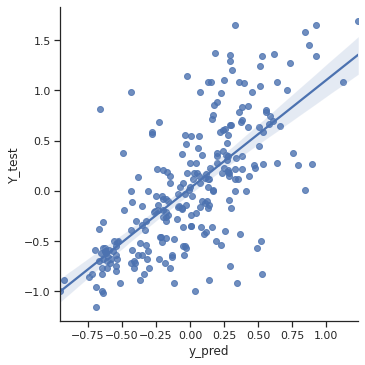

1
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
250
2-fold :  57.199999999999996
3-fold :  75.6
5-fold :  89.60000000000001
gmfe :  2.1890103989570098
mfe :  1.3006567442522394
bias :  0.022391174031828998
rmse  0.44833193699513063
r2  0.5564365888321724


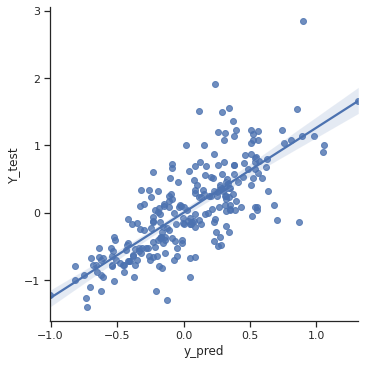

2
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
250
2-fold :  54.800000000000004
3-fold :  70.0
5-fold :  90.0
gmfe :  2.1874181490291593
mfe :  1.3075349281761253
bias :  0.05101526971359999
rmse  0.4447103838525701
r2  0.5266773946120178


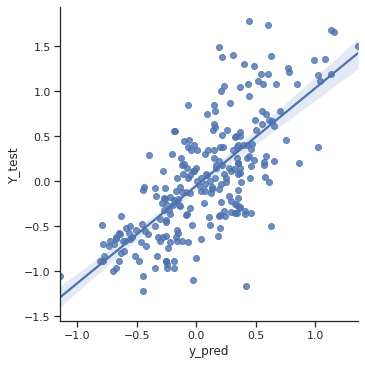

3
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
250
2-fold :  61.6
3-fold :  77.2
5-fold :  90.4
gmfe :  2.0371506613489045
mfe :  1.2835488359205058
bias :  0.03511299384354251
rmse  0.4144723278558707
r2  0.528372786860704


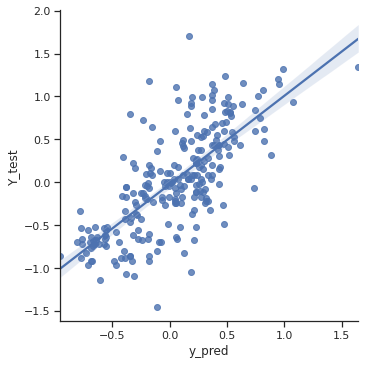

4
(1000, 513)
(249, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
249
2-fold :  63.45381526104418
3-fold :  81.52610441767068
5-fold :  91.96787148594377
gmfe :  2.01333556226848
mfe :  1.2714835812801126
bias :  -0.007258439365008126
rmse  0.40657229425749664
r2  0.5883739050776382
saving model


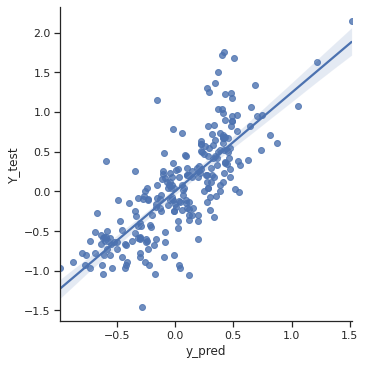

0
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
250
2-fold :  57.99999999999999
3-fold :  74.0
5-fold :  88.4
gmfe :  2.1829958764378277
mfe :  1.2904504777926635
bias :  0.011603514125416936
rmse  0.4648935742048389
r2  0.47776194209359923


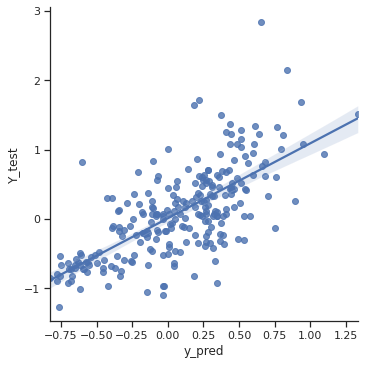

1
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
250
2-fold :  58.4
3-fold :  78.4
5-fold :  88.8
gmfe :  2.057322109154454
mfe :  1.259866139362205
bias :  0.03236145194560239
rmse  0.4204128279594944
r2  0.4991333724493753


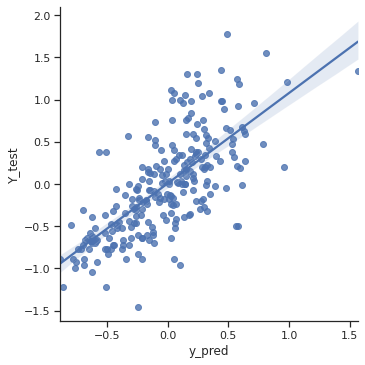

2
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
250
2-fold :  56.39999999999999
3-fold :  75.2
5-fold :  88.0
gmfe :  2.2192083570347103
mfe :  1.2804456401882318
bias :  -0.006587031778265251
rmse  0.47163124809836604
r2  0.5129192827938421


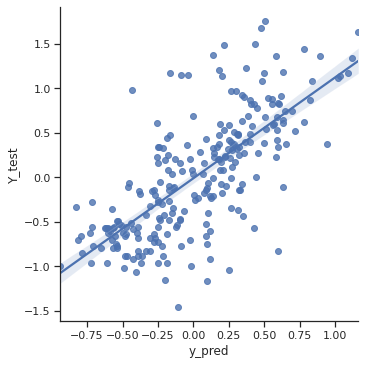

3
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
250
2-fold :  55.2
3-fold :  74.4
5-fold :  87.6
gmfe :  2.146489915624887
mfe :  1.2990080241603865
bias :  0.12139005347501203
rmse  0.4270804434272099
r2  0.537180227560039


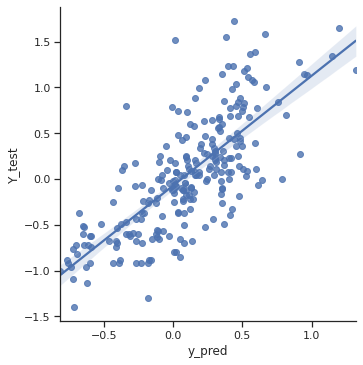

4
(1000, 513)
(249, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
249
2-fold :  56.22489959839358
3-fold :  74.69879518072288
5-fold :  91.16465863453816
gmfe :  2.0442820360269196
mfe :  1.2820113219070408
bias :  0.027479264403049597
rmse  0.4039953873613071
r2  0.6145382899897911


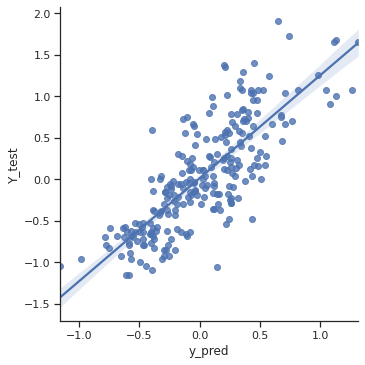

0
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
250
2-fold :  54.400000000000006
3-fold :  77.2
5-fold :  89.60000000000001
gmfe :  2.1433093292996173
mfe :  1.3003976213460169
bias :  0.023144064943441428
rmse  0.4336548392715274
r2  0.5182122526393997


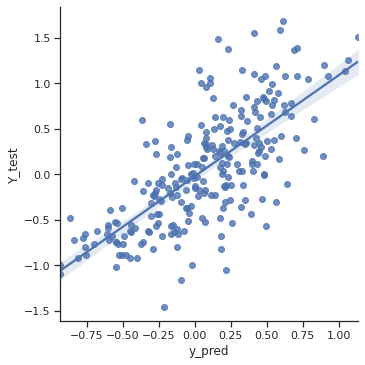

1
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
250
2-fold :  58.8
3-fold :  75.2
5-fold :  89.60000000000001
gmfe :  2.133464106353884
mfe :  1.2855220293620766
bias :  0.0985059837230223
rmse  0.4384213942905577
r2  0.5461207607941467


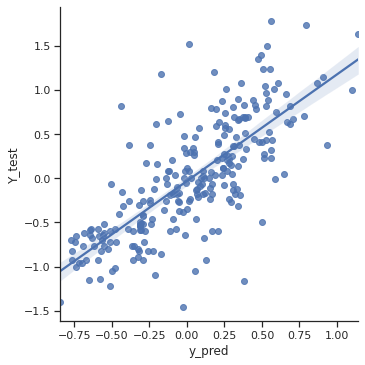

2
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
250
2-fold :  59.599999999999994
3-fold :  76.0
5-fold :  89.60000000000001
gmfe :  2.079202595815126
mfe :  1.264242497977449
bias :  0.006749009584584589
rmse  0.43000184302300737
r2  0.5441805936640101


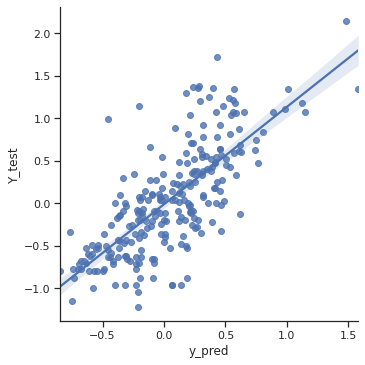

3
(999, 513)
(250, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
250
2-fold :  52.800000000000004
3-fold :  74.4
5-fold :  91.2
gmfe :  2.1657568265637392
mfe :  1.3225511703619919
bias :  -0.0027396879937273966
rmse  0.43355236723907653
r2  0.5568341933800338


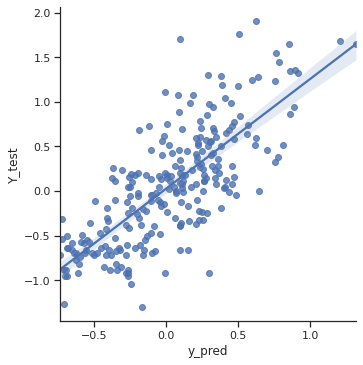

4
(1000, 513)
(249, 513)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
249
2-fold :  57.028112449799195
3-fold :  75.90361445783132
5-fold :  89.95983935742971
gmfe :  2.1287050014311384
mfe :  1.2781281408713314
bias :  0.024316128682877525
rmse  0.44074563987748505
r2  0.5154728316202133


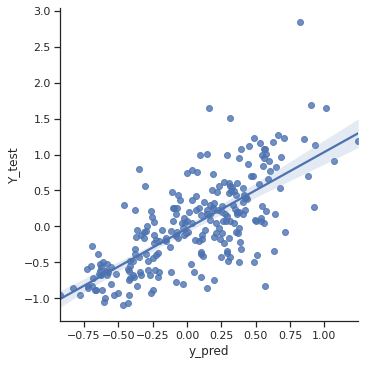

human_CL_mL_min_kg
0
(1024, 513)
(257, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
257
2-fold :  51.36186770428015
3-fold :  73.54085603112841
5-fold :  82.87937743190662
gmfe :  2.528205973008689
mfe :  1.347681800033544
bias :  -0.06885536952106386
rmse  0.5661525056943176
r2  0.29717520294927724
saving model


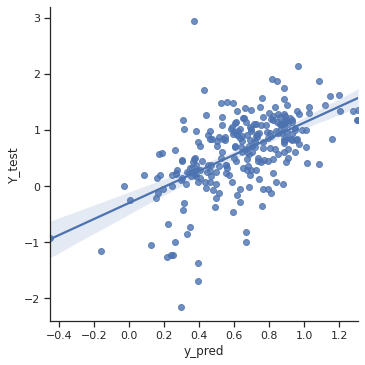

1
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
256
2-fold :  49.21875
3-fold :  71.875
5-fold :  85.9375
gmfe :  2.4143771791731834
mfe :  1.3590107440238381
bias :  -0.4028963330890333
rmse  0.5183338368827137
r2  0.3386459991431492
saving model


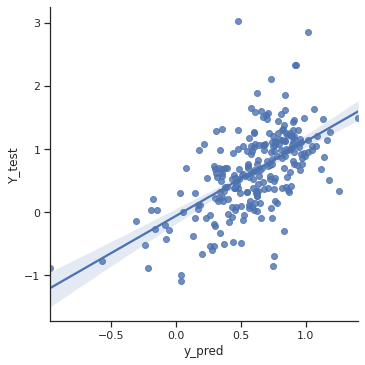

2
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
256
2-fold :  51.171875
3-fold :  73.4375
5-fold :  85.15625
gmfe :  2.4276613372327187
mfe :  1.3386151412081233
bias :  -0.26110041975557396
rmse  0.5196814761826792
r2  0.25176854813547767


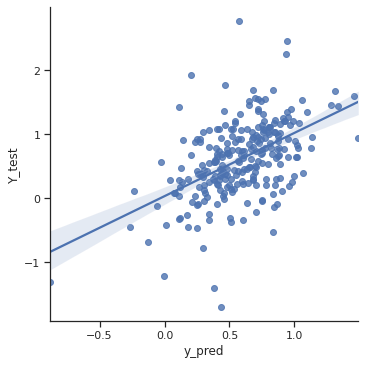

3
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
256
2-fold :  51.5625
3-fold :  69.53125
5-fold :  86.328125
gmfe :  2.4460470520881206
mfe :  1.3403593819084052
bias :  -0.671458664824629
rmse  0.528178036950566
r2  0.3552026008435476


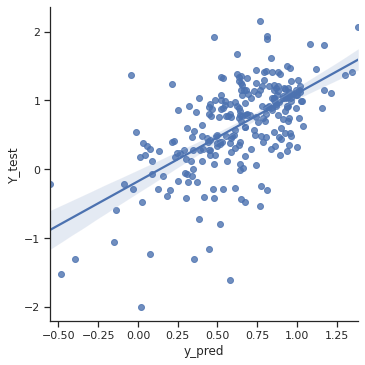

4
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
256
2-fold :  48.828125
3-fold :  67.1875
5-fold :  81.640625
gmfe :  2.6636995941297834
mfe :  1.3641791229843765
bias :  -0.033694761472069734
rmse  0.5968127726427899
r2  0.20429140634873355


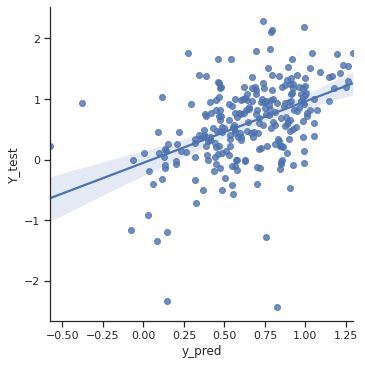

0
(1024, 513)
(257, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
257
2-fold :  51.36186770428015
3-fold :  64.98054474708171
5-fold :  82.49027237354085
gmfe :  2.673671966059551
mfe :  1.3380895638015877
bias :  -0.12147503911143342
rmse  0.6063096823244629
r2  0.2748603589936074


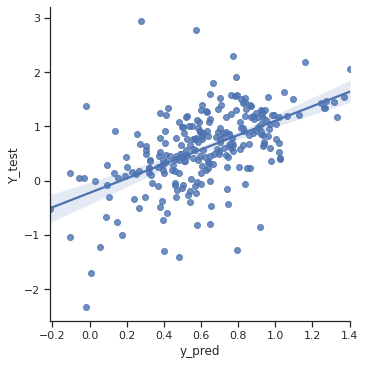

1
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
Calculating Permutation Importances
256
2-fold :  42.578125
3-fold :  65.625
5-fold :  82.03125
gmfe :  2.7923793230312173
mfe :  1.4065477205949446
bias :  -0.30523888452685255
rmse  0.6003874828336574
r2  0.2797254640656275


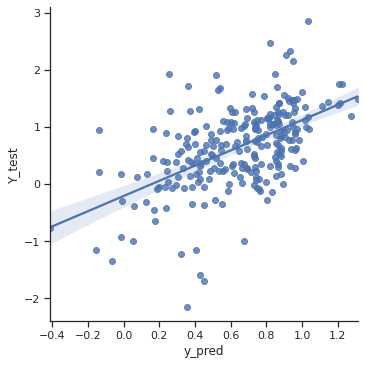

2
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=43)
Calculating Permutation Importances
256
2-fold :  48.046875
3-fold :  71.09375
5-fold :  84.765625
gmfe :  2.4261447073638154
mfe :  1.3714426282490748
bias :  -0.43099407722380834
rmse  0.5070098366212866
r2  0.28862191615686283


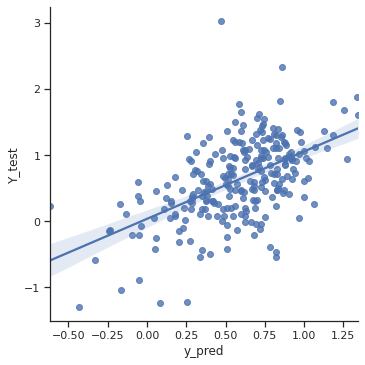

3
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=43)
Calculating Permutation Importances
256
2-fold :  55.46875
3-fold :  73.828125
5-fold :  86.328125
gmfe :  2.3207870906248433
mfe :  1.2994959606906824
bias :  -0.3469484106489671
rmse  0.4939073598579051
r2  0.3304532008748401
saving model


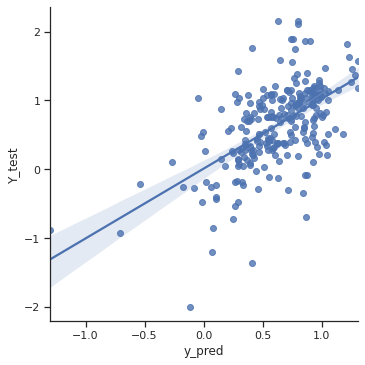

4
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
Calculating Permutation Importances
256
2-fold :  53.515625
3-fold :  70.703125
5-fold :  88.28125
gmfe :  2.2720552072303257
mfe :  1.2918580182855175
bias :  -0.22486892413182114
rmse  0.48852095190857275
r2  0.35494412738577896
saving model


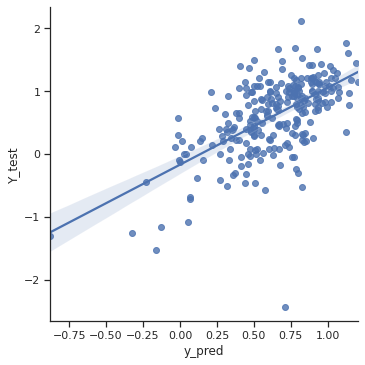

0
(1024, 513)
(257, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
257
2-fold :  54.08560311284047
3-fold :  72.37354085603113
5-fold :  87.93774319066148
gmfe :  2.3552199404325416
mfe :  1.3295937373319442
bias :  -0.23621448221999053
rmse  0.5061021772322538
r2  0.3663841170302705


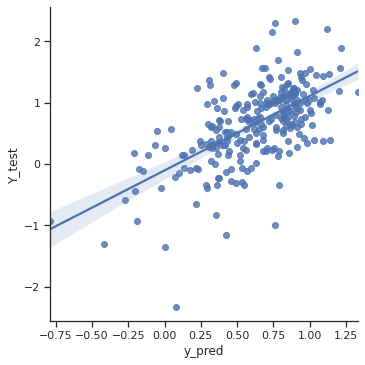

1
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
256
2-fold :  53.515625
3-fold :  73.828125
5-fold :  86.328125
gmfe :  2.3511173464123045
mfe :  1.3039937111685083
bias :  -0.46346768037889363
rmse  0.5184706806096111
r2  0.3183755603991879


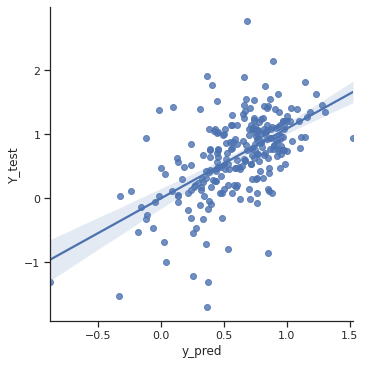

2
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=44)
Calculating Permutation Importances
256
2-fold :  53.125
3-fold :  70.3125
5-fold :  81.640625
gmfe :  2.5026371476363773
mfe :  1.3204130975938264
bias :  0.2533588223063366
rmse  0.5515117652952567
r2  0.3275279135792646


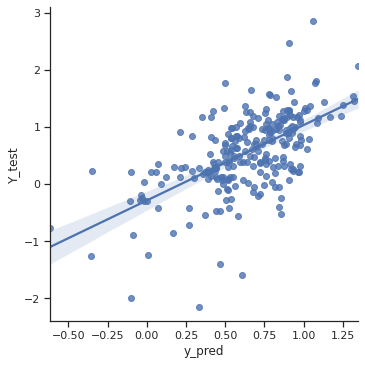

3
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=44)
Calculating Permutation Importances
256
2-fold :  49.609375
3-fold :  66.40625
5-fold :  85.15625
gmfe :  2.656403523264758
mfe :  1.359041436720977
bias :  -0.06519714414652596
rmse  0.588113370023746
r2  0.24442198145181815


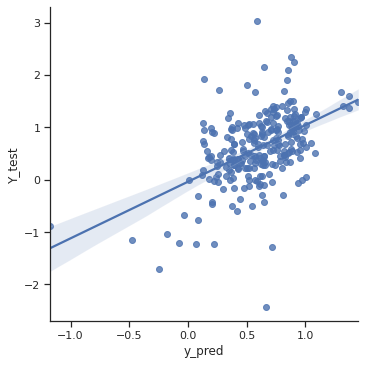

4
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
256
2-fold :  49.609375
3-fold :  69.140625
5-fold :  83.984375
gmfe :  2.4175702905844876
mfe :  1.3577429250870574
bias :  -0.39410737220409064
rmse  0.5154695351432517
r2  0.3153628082780051


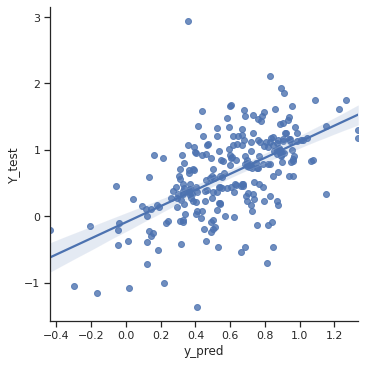

0
(1024, 513)
(257, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
257
2-fold :  46.69260700389105
3-fold :  71.20622568093385
5-fold :  89.49416342412452
gmfe :  2.3593066947807677
mfe :  1.3972759746781627
bias :  -0.6012645032957875
rmse  0.4649075947058686
r2  0.3510830501226252


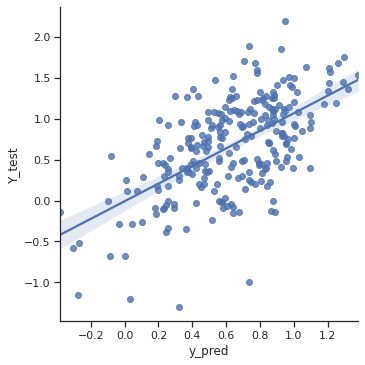

1
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=45)
Calculating Permutation Importances
256
2-fold :  52.34375
3-fold :  68.75
5-fold :  82.03125
gmfe :  2.413336053105008
mfe :  1.3293961874335998
bias :  0.29722289938911706
rmse  0.5017410975592191
r2  0.3251662249568358


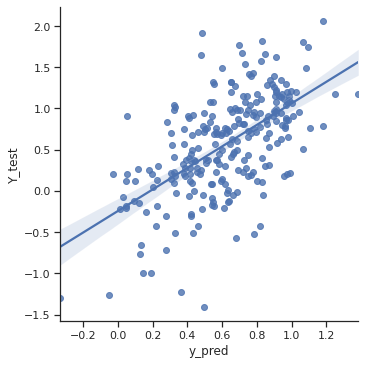

2
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
256
2-fold :  50.390625
3-fold :  70.3125
5-fold :  82.421875
gmfe :  2.5860021911409032
mfe :  1.3480850618167342
bias :  -0.8903933702749609
rmse  0.5834360591094666
r2  0.23449783600700325


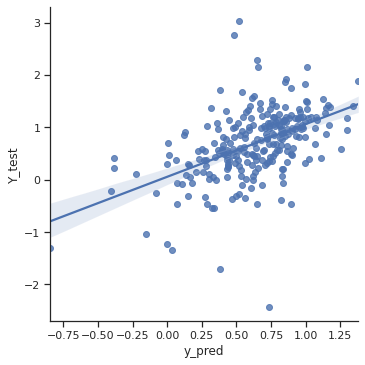

3
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
Calculating Permutation Importances
256
2-fold :  54.296875
3-fold :  70.703125
5-fold :  85.15625
gmfe :  2.4339114571295872
mfe :  1.2962083063132932
bias :  -0.10818354650339784
rmse  0.5425738174557936
r2  0.2814973025149693


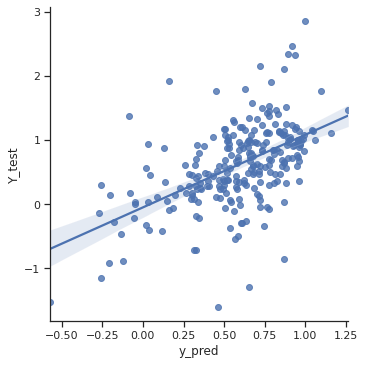

4
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
256
2-fold :  51.5625
3-fold :  69.53125
5-fold :  83.59375
gmfe :  2.631213001008563
mfe :  1.3438910220141587
bias :  -0.2197693307929499
rmse  0.606899612196504
r2  0.3083412110808422


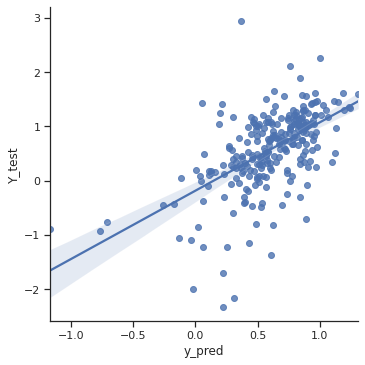

0
(1024, 513)
(257, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=46)
Calculating Permutation Importances
257
2-fold :  51.36186770428015
3-fold :  70.03891050583657
5-fold :  84.04669260700389
gmfe :  2.505948536542045
mfe :  1.3465358605147308
bias :  -0.7879341572873226
rmse  0.5603139571642273
r2  0.2203941114680842


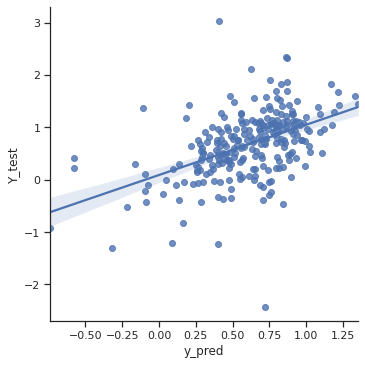

1
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
256
2-fold :  46.09375
3-fold :  65.234375
5-fold :  80.859375
gmfe :  2.7239647125484816
mfe :  1.3826443954844527
bias :  -0.11046653882180735
rmse  0.5935786851094331
r2  0.3130655466791482


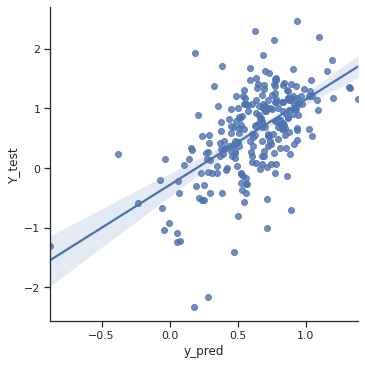

2
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
256
2-fold :  52.734375
3-fold :  71.09375
5-fold :  82.8125
gmfe :  2.4608999346649614
mfe :  1.3142773635440708
bias :  0.14277085250430044
rmse  0.5579152766559953
r2  0.291539654211311


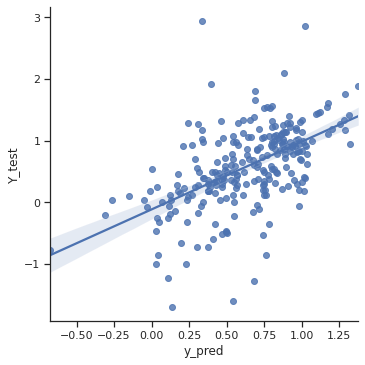

3
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
256
2-fold :  48.828125
3-fold :  67.578125
5-fold :  85.9375
gmfe :  2.480995058410836
mfe :  1.3600178545740735
bias :  -0.08986360173427088
rmse  0.5251789960821901
r2  0.33899629178058066


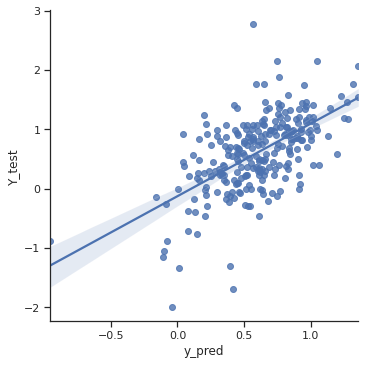

4
(1025, 513)
(256, 513)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
256
2-fold :  52.734375
3-fold :  75.0
5-fold :  89.453125
gmfe :  2.250950635582939
mfe :  1.3265463505866015
bias :  -0.42716988619004775
rmse  0.4575211190916764
r2  0.36146580738856526
saving model


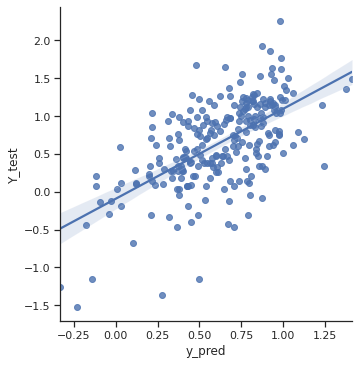

human_fup
0
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
176
2-fold :  52.27272727272727
3-fold :  61.93181818181818
5-fold :  74.43181818181817
gmfe :  3.115648190840374
mfe :  1.3069119432204892
bias :  0.05299819008833351
rmse  0.20688277602465932
r2  0.6531336552342126
saving model


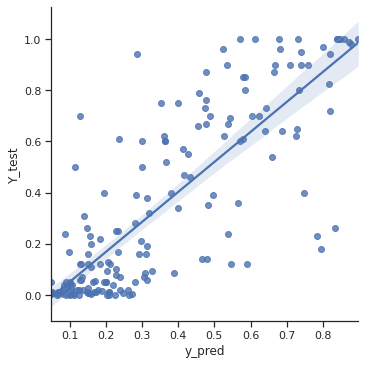

1
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
176
2-fold :  55.68181818181818
3-fold :  71.5909090909091
5-fold :  79.54545454545455
gmfe :  2.7413868005136814
mfe :  1.2891763802934189
bias :  0.05083200744886536
rmse  0.2011978465700598
r2  0.6004885134071556
saving model


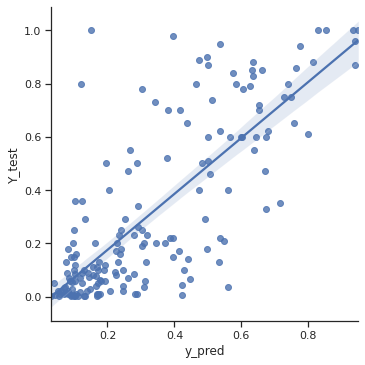

2
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
176
2-fold :  57.38636363636363
3-fold :  72.72727272727273
5-fold :  82.38636363636364
gmfe :  2.5222650518960585
mfe :  1.2625132680132014
bias :  -0.008768584010463244
rmse  0.23368884412370627
r2  0.5454797414082704
saving model


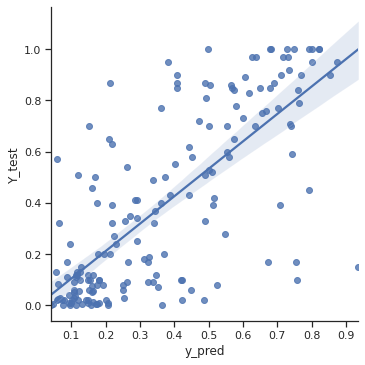

3
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
176
2-fold :  55.11363636363637
3-fold :  66.47727272727273
5-fold :  77.27272727272727
gmfe :  2.7337047080233017
mfe :  1.2892998022650566
bias :  0.051024887020911215
rmse  0.2193186984964361
r2  0.5989149423994344


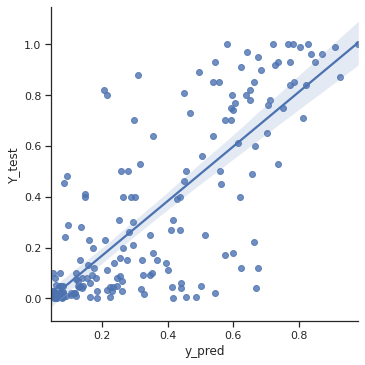

4
(704, 513)
(175, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
175
2-fold :  54.285714285714285
3-fold :  67.42857142857143
5-fold :  76.0
gmfe :  2.716126539842408
mfe :  1.2499211771329666
bias :  0.05013484380608553
rmse  0.20023234921727848
r2  0.6446267549564879


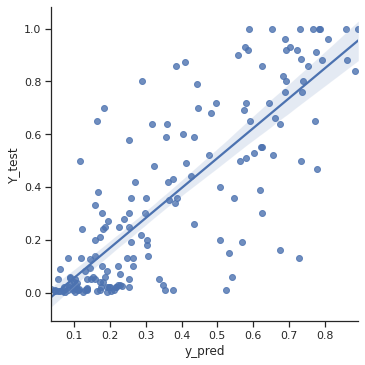

0
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=43)
Calculating Permutation Importances
176
2-fold :  52.27272727272727
3-fold :  65.9090909090909
5-fold :  78.97727272727273
gmfe :  2.685495114930507
mfe :  1.3167039545242751
bias :  0.04134487031287437
rmse  0.2221782242734214
r2  0.5699919337553845


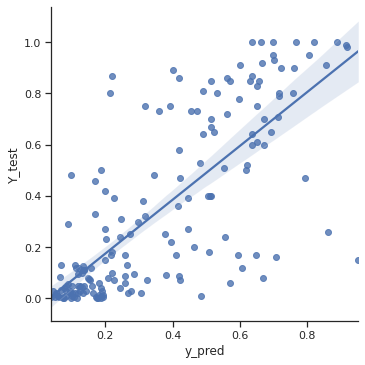

1
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
176
2-fold :  58.52272727272727
3-fold :  65.3409090909091
5-fold :  78.4090909090909
gmfe :  2.7367247387271214
mfe :  1.248510863645424
bias :  0.03774264135146824
rmse  0.19904099156071206
r2  0.6160406537138033


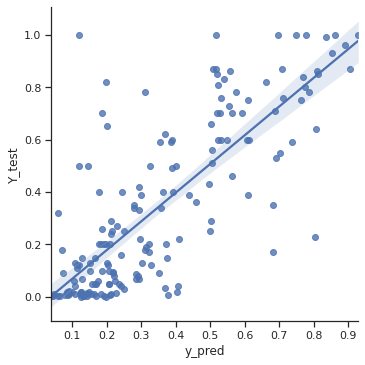

2
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=43)
Calculating Permutation Importances
176
2-fold :  52.84090909090909
3-fold :  67.61363636363636
5-fold :  75.0
gmfe :  3.101727219111205
mfe :  1.2856443779360212
bias :  0.043670914886518364
rmse  0.2300944716869789
r2  0.6117706522962216


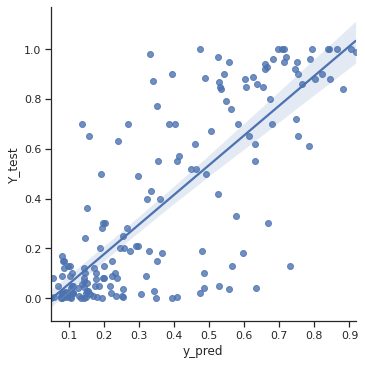

3
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
176
2-fold :  55.68181818181818
3-fold :  69.31818181818183
5-fold :  76.70454545454545
gmfe :  2.9452740025782274
mfe :  1.309365277397164
bias :  0.0362578914213167
rmse  0.23541782169098907
r2  0.5630910896977687


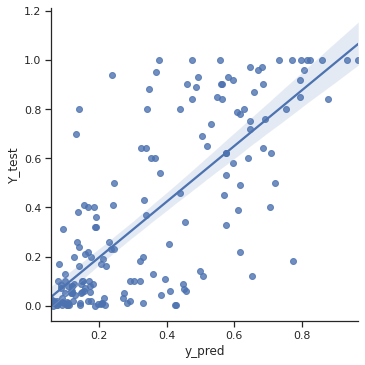

4
(704, 513)
(175, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=43)
Calculating Permutation Importances
175
2-fold :  56.57142857142857
3-fold :  70.28571428571428
5-fold :  82.85714285714286
gmfe :  2.3973841154064224
mfe :  1.2802655860082142
bias :  0.029047128051282074
rmse  0.18640433841191376
r2  0.6450604360984098
saving model


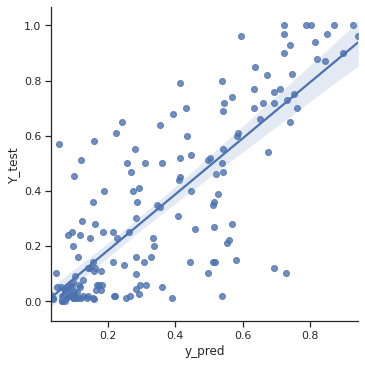

0
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
176
2-fold :  57.38636363636363
3-fold :  71.02272727272727
5-fold :  82.95454545454545
gmfe :  2.449833460996143
mfe :  1.2706041625020301
bias :  0.04422315802880397
rmse  0.20217518670578183
r2  0.6647596542533714


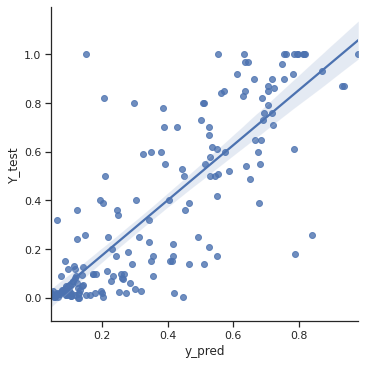

1
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
176
2-fold :  52.84090909090909
3-fold :  64.77272727272727
5-fold :  76.13636363636364
gmfe :  2.8116451596654057
mfe :  1.3017276248447067
bias :  0.038831914676499046
rmse  0.21497747336788994
r2  0.5770822393368158


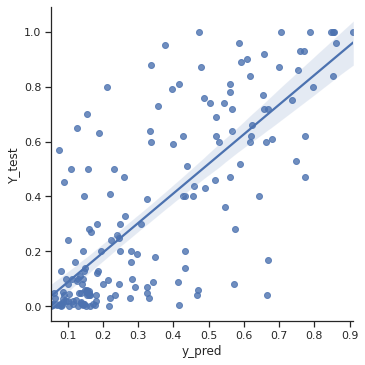

2
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
176
2-fold :  55.68181818181818
3-fold :  67.04545454545455
5-fold :  76.13636363636364
gmfe :  2.907593999612934
mfe :  1.2622662203382393
bias :  0.0331320633078777
rmse  0.21052187817571116
r2  0.614321637346734


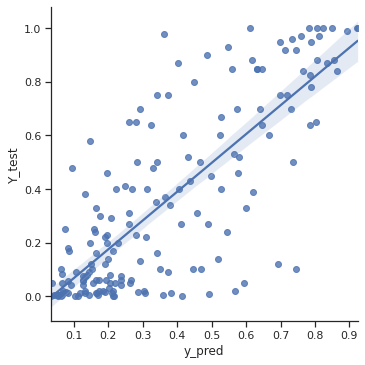

3
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
176
2-fold :  57.95454545454546
3-fold :  69.31818181818183
5-fold :  80.11363636363636
gmfe :  2.8138639131859553
mfe :  1.261252646256663
bias :  0.031850180773809314
rmse  0.21528313021149262
r2  0.6264641467297529


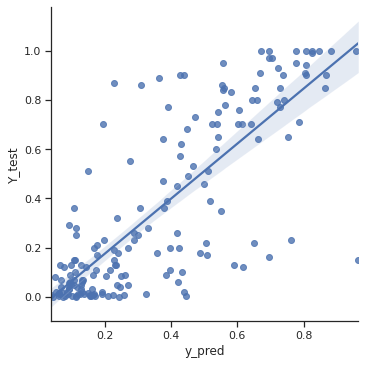

4
(704, 513)
(175, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
175
2-fold :  54.285714285714285
3-fold :  63.42857142857142
5-fold :  75.42857142857143
gmfe :  2.730973065810647
mfe :  1.3014102370759122
bias :  0.045551271117431055
rmse  0.20799703158638777
r2  0.6028404573019357


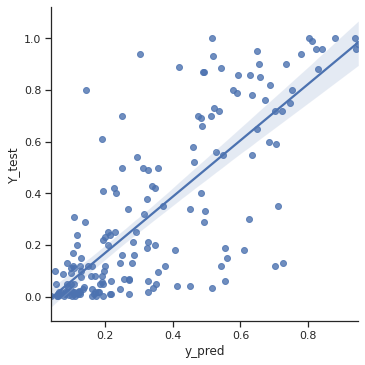

0
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
176
2-fold :  47.72727272727273
3-fold :  62.5
5-fold :  76.70454545454545
gmfe :  3.176738441744214
mfe :  1.385345673245202
bias :  0.06303878838698557
rmse  0.21893041980468944
r2  0.48774631866351625


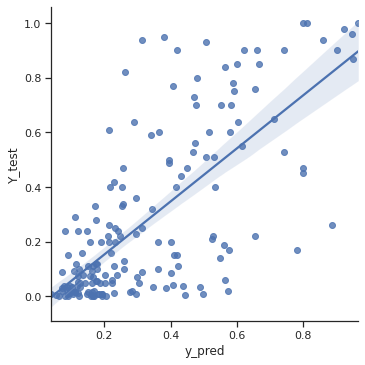

1
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
Calculating Permutation Importances
176
2-fold :  53.97727272727273
3-fold :  64.77272727272727
5-fold :  78.97727272727273
gmfe :  2.669053082953234
mfe :  1.3202886930981597
bias :  0.032818293341993945
rmse  0.23908628939634802
r2  0.506033925488297


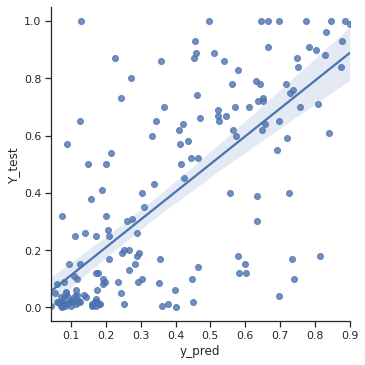

2
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
176
2-fold :  57.38636363636363
3-fold :  69.31818181818183
5-fold :  78.97727272727273
gmfe :  2.675586876582853
mfe :  1.2730725906272558
bias :  0.025247300285779574
rmse  0.20967199526470515
r2  0.6523524052499532


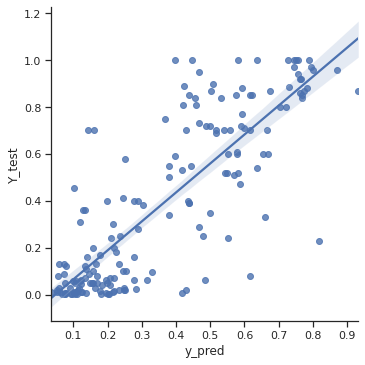

3
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
Calculating Permutation Importances
176
2-fold :  59.09090909090909
3-fold :  69.31818181818183
5-fold :  77.8409090909091
gmfe :  2.631335085508842
mfe :  1.258519529937866
bias :  0.04858629408371749
rmse  0.20032276384475473
r2  0.6471360260134247


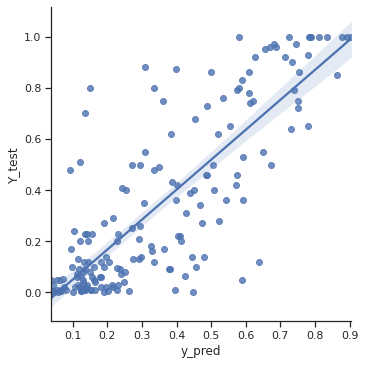

4
(704, 513)
(175, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
175
2-fold :  61.142857142857146
3-fold :  72.0
5-fold :  79.42857142857143
gmfe :  2.698501662841993
mfe :  1.2417534825380874
bias :  0.03169665701099199
rmse  0.20149412032236255
r2  0.6736195268776601


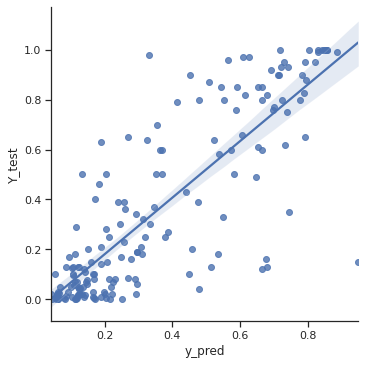

0
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=46)
Calculating Permutation Importances
176
2-fold :  53.40909090909091
3-fold :  64.77272727272727
5-fold :  75.56818181818183
gmfe :  3.0338889636473096
mfe :  1.302754436560134
bias :  0.04946558071294961
rmse  0.2235300510875992
r2  0.5915664237195237


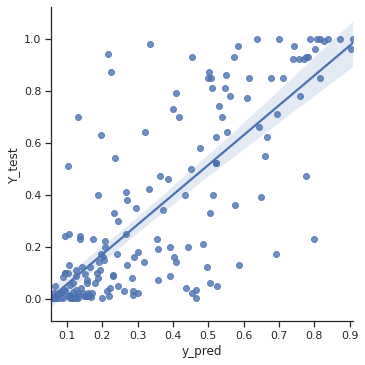

1
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
176
2-fold :  57.95454545454546
3-fold :  69.31818181818183
5-fold :  80.68181818181817
gmfe :  2.660192970675147
mfe :  1.2589353102683414
bias :  0.014501022806882938
rmse  0.20430639070293222
r2  0.621159253917654


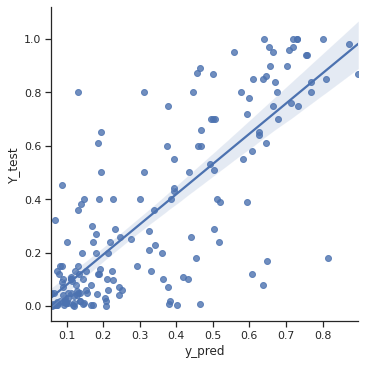

2
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
176
2-fold :  52.84090909090909
3-fold :  65.9090909090909
5-fold :  78.4090909090909
gmfe :  2.740345613684391
mfe :  1.3141018769966752
bias :  0.04726690956799523
rmse  0.21686225315572263
r2  0.6075534267890836


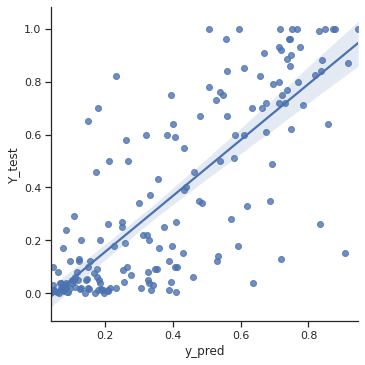

3
(703, 513)
(176, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
176
2-fold :  61.36363636363637
3-fold :  71.02272727272727
5-fold :  80.68181818181817
gmfe :  2.6458347715198944
mfe :  1.2383453956360635
bias :  0.03153156380285635
rmse  0.18894065975254487
r2  0.6694177780657584


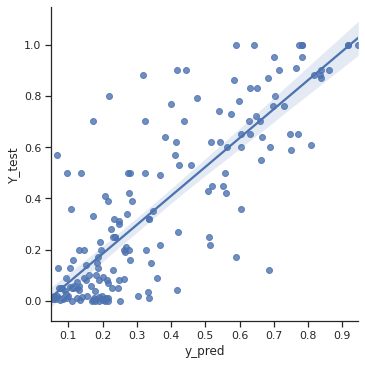

4
(704, 513)
(175, 513)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=46)
Calculating Permutation Importances
175
2-fold :  52.0
3-fold :  62.28571428571429
5-fold :  76.57142857142857
gmfe :  2.7527506740042442
mfe :  1.326011944578428
bias :  0.0455352517290174
rmse  0.2202438114038933
r2  0.5963084949235882


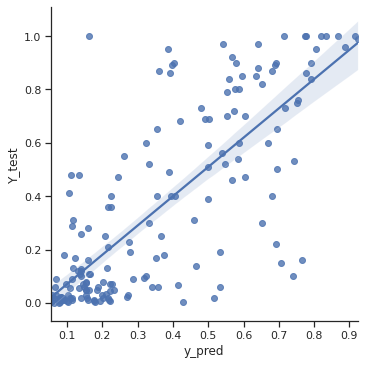

human_mrt
0
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=8, n_jobs=30, random_state=42)
Calculating Permutation Importances
249
2-fold :  43.77510040160642
3-fold :  71.8875502008032
5-fold :  83.13253012048193
gmfe :  2.5577706872495822
mfe :  1.412113210843184
bias :  0.04916140625944898
rmse  0.5375805332173104
r2  0.24891128651057293
saving model


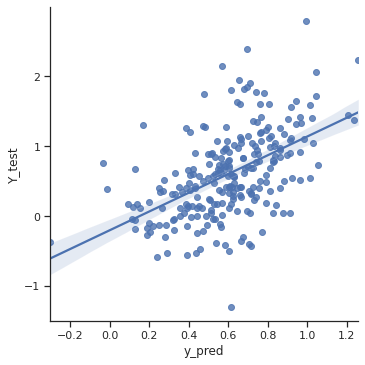

1
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
249
2-fold :  48.59437751004016
3-fold :  71.08433734939759
5-fold :  86.74698795180723
gmfe :  2.469141233620272
mfe :  1.365870133815869
bias :  -0.37084949630854025
rmse  0.5272724571243087
r2  0.2342817577696341
saving model


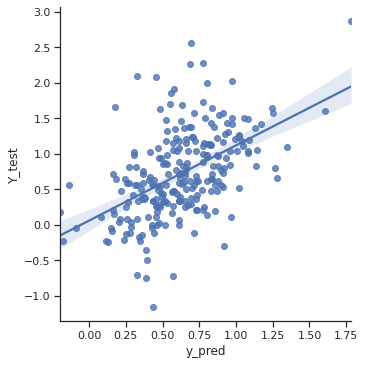

2
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
249
2-fold :  53.01204819277109
3-fold :  72.28915662650603
5-fold :  83.53413654618474
gmfe :  2.5378822214537227
mfe :  1.3178590652644189
bias :  -0.019309920125568425
rmse  0.560348632274992
r2  0.28312040174028663


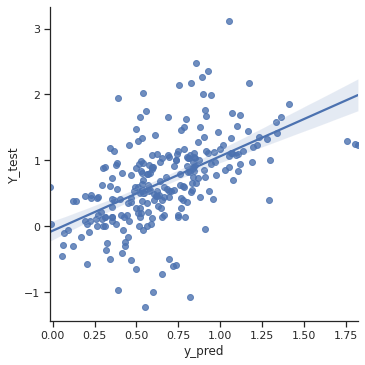

3
(995, 513)
(248, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
Calculating Permutation Importances
248
2-fold :  49.596774193548384
3-fold :  69.75806451612904
5-fold :  81.85483870967742
gmfe :  2.5692946964282757
mfe :  1.3573461454691826
bias :  -0.10655220067524473
rmse  0.5858536035274272
r2  0.28459111216617916


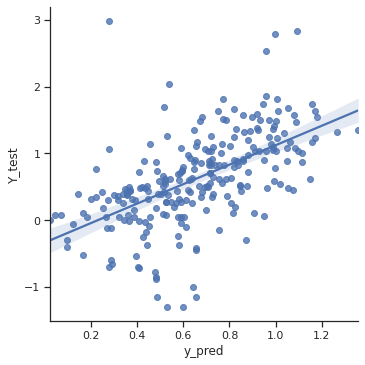

4
(995, 513)
(248, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=42)
Calculating Permutation Importances
248
2-fold :  50.806451612903224
3-fold :  68.95161290322581
5-fold :  84.2741935483871
gmfe :  2.495748802855753
mfe :  1.3415131598258327
bias :  0.38197730915446826
rmse  0.534624754701649
r2  0.24796926747935255


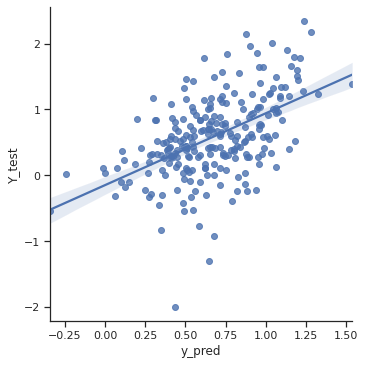

0
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
249
2-fold :  47.389558232931726
3-fold :  71.08433734939759
5-fold :  83.93574297188755
gmfe :  2.5283754517645693
mfe :  1.3779541995049358
bias :  -0.12804008757159346
rmse  0.5513891408364798
r2  0.2618413253577351


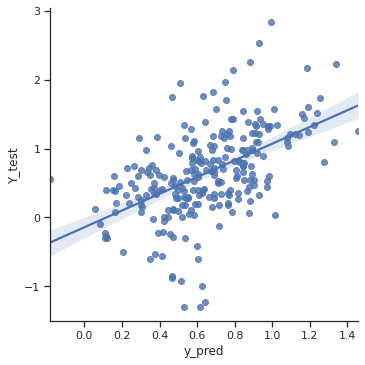

1
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
Calculating Permutation Importances
249
2-fold :  45.38152610441767
3-fold :  67.8714859437751
5-fold :  79.51807228915662
gmfe :  2.725496482475649
mfe :  1.3913972339161902
bias :  -0.01634903904035756
rmse  0.5932024038697078
r2  0.2703734869050788


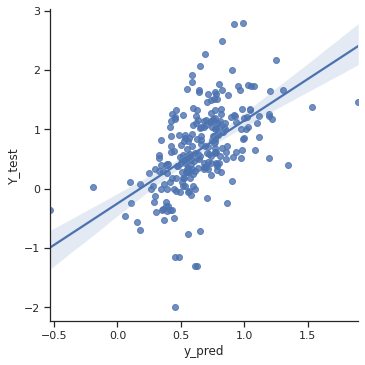

2
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
Calculating Permutation Importances
249
2-fold :  48.19277108433735
3-fold :  67.46987951807229
5-fold :  83.53413654618474
gmfe :  2.4688380039555744
mfe :  1.3682025531516468
bias :  0.05557196736961045
rmse  0.516549740245172
r2  0.2885077855847311
saving model


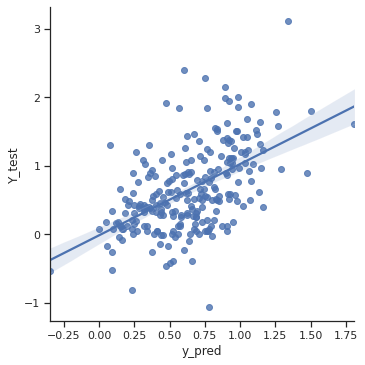

3
(995, 513)
(248, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
Calculating Permutation Importances
248
2-fold :  51.61290322580645
3-fold :  71.7741935483871
5-fold :  80.64516129032258
gmfe :  2.5919165792502072
mfe :  1.3377812298296896
bias :  0.031669276326674045
rmse  0.5779878863767425
r2  0.23064803074127493


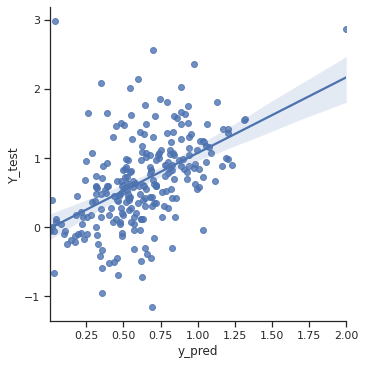

4
(995, 513)
(248, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=43)
Calculating Permutation Importances
248
2-fold :  56.85483870967742
3-fold :  73.79032258064517
5-fold :  85.48387096774194
gmfe :  2.265073434049602
mfe :  1.3052259314692194
bias :  0.30824411226677295
rmse  0.4792258551397219
r2  0.3478423645782871
saving model


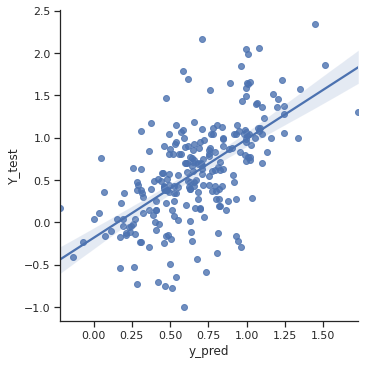

0
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
249
2-fold :  51.80722891566265
3-fold :  71.4859437751004
5-fold :  86.34538152610442
gmfe :  2.387271184480908
mfe :  1.3440043519694378
bias :  -0.04579227806755748
rmse  0.5038673219749186
r2  0.27865665269910433


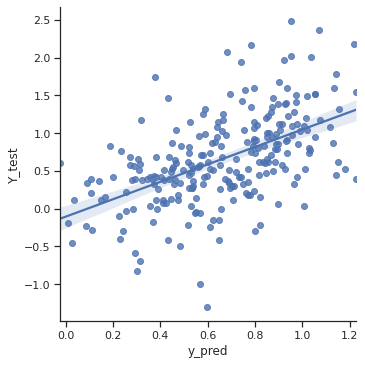

1
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
249
2-fold :  52.610441767068274
3-fold :  69.87951807228916
5-fold :  81.92771084337349
gmfe :  2.626106301096741
mfe :  1.3240832493730508
bias :  0.2586355757662986
rmse  0.5987681972671045
r2  0.2519809274429551


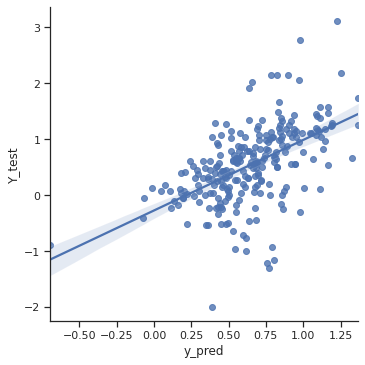

2
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
249
2-fold :  46.58634538152611
3-fold :  70.28112449799197
5-fold :  83.13253012048193
gmfe :  2.494581144074798
mfe :  1.3765634423067497
bias :  0.03977115717406887
rmse  0.5265613285912801
r2  0.2842614725780258


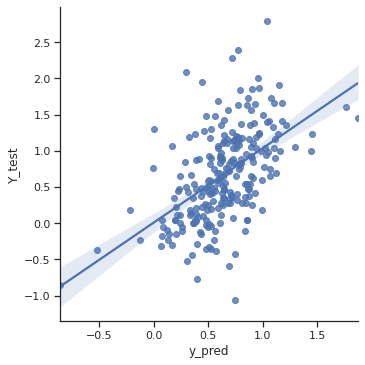

3
(995, 513)
(248, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
248
2-fold :  51.20967741935484
3-fold :  69.35483870967742
5-fold :  82.25806451612904
gmfe :  2.5247094321867505
mfe :  1.337985681521629
bias :  0.2722396394305038
rmse  0.5440740366277428
r2  0.2440708055040317


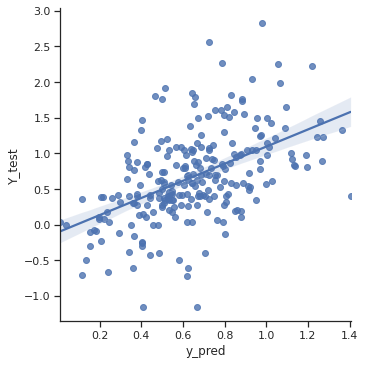

4
(995, 513)
(248, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
248
2-fold :  47.17741935483871
3-fold :  71.37096774193549
5-fold :  82.25806451612904
gmfe :  2.495442099533995
mfe :  1.3679094088228203
bias :  -0.1778398358938088
rmse  0.541415904666817
r2  0.3259654007979187


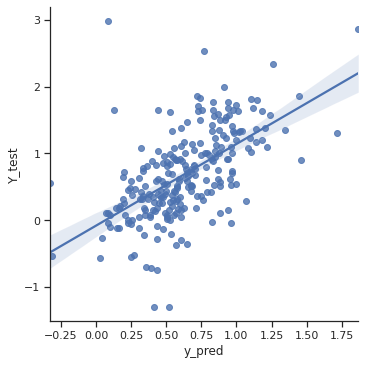

0
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
249
2-fold :  51.00401606425703
3-fold :  69.07630522088354
5-fold :  84.33734939759037
gmfe :  2.528472541464981
mfe :  1.3457777337654309
bias :  -0.35690887506194535
rmse  0.5553838583767671
r2  0.23190549013357553


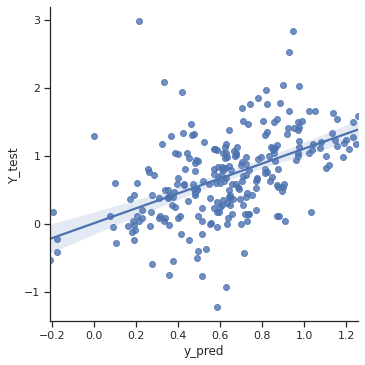

1
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=45)
Calculating Permutation Importances
249
2-fold :  46.98795180722892
3-fold :  68.27309236947792
5-fold :  81.52610441767068
gmfe :  2.763673945724196
mfe :  1.4209386030889444
bias :  0.12841095014047177
rmse  0.6029796814224909
r2  0.25571677835891493


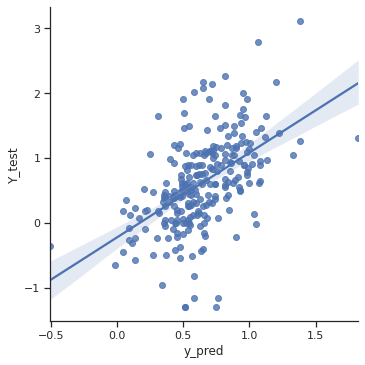

2
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
Calculating Permutation Importances
249
2-fold :  53.01204819277109
3-fold :  74.29718875502009
5-fold :  85.14056224899599
gmfe :  2.4190965700433162
mfe :  1.3230064174655407
bias :  -0.09981861083226962
rmse  0.5288811878921684
r2  0.3060043360853465


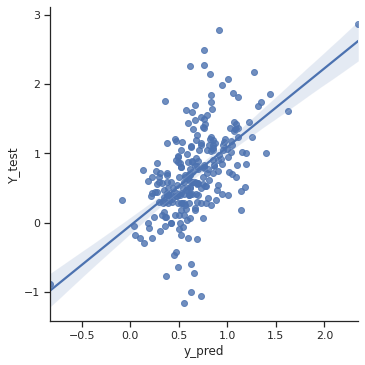

3
(995, 513)
(248, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
248
2-fold :  47.58064516129033
3-fold :  73.38709677419355
5-fold :  83.87096774193549
gmfe :  2.392635060195966
mfe :  1.3633033081329915
bias :  0.02639065298420952
rmse  0.4951694563130475
r2  0.3251745913085101


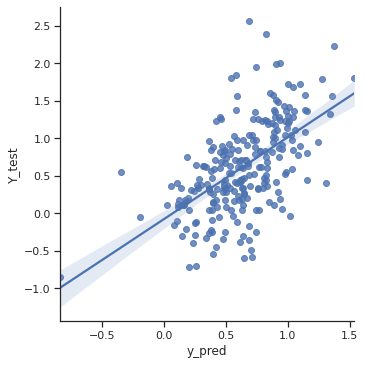

4
(995, 513)
(248, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=45)
Calculating Permutation Importances
248
2-fold :  48.38709677419355
3-fold :  68.54838709677419
5-fold :  81.45161290322581
gmfe :  2.5368482276592106
mfe :  1.359828650383147
bias :  0.5681998156824083
rmse  0.5407582260172397
r2  0.24974200863991414


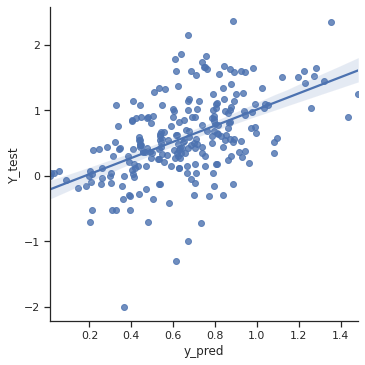

0
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=46)
Calculating Permutation Importances
249
2-fold :  46.58634538152611
3-fold :  68.27309236947792
5-fold :  81.92771084337349
gmfe :  2.646481041949671
mfe :  1.3692755682725808
bias :  -0.057246523644490566
rmse  0.5658752949824187
r2  0.29067533263502476


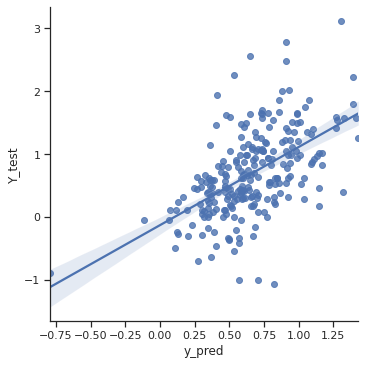

1
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
249
2-fold :  54.61847389558233
3-fold :  74.69879518072288
5-fold :  83.93574297188755
gmfe :  2.3859099303781766
mfe :  1.3244915665575296
bias :  -0.08805749112401151
rmse  0.5081141558671673
r2  0.3357489721886119


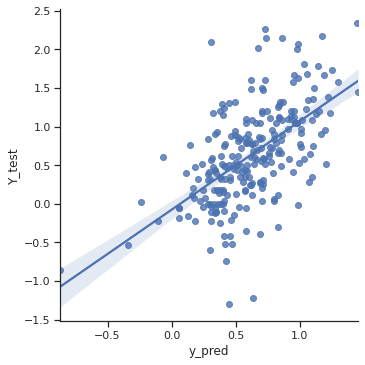

2
(994, 513)
(249, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
249
2-fold :  53.81526104417671
3-fold :  75.1004016064257
5-fold :  86.34538152610442
gmfe :  2.290991282219943
mfe :  1.3183462955702532
bias :  -0.09642310938018284
rmse  0.4950824955224927
r2  0.33925305763226377


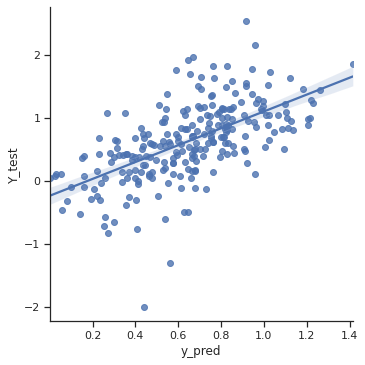

3
(995, 513)
(248, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
Calculating Permutation Importances
248
2-fold :  45.96774193548387
3-fold :  65.7258064516129
5-fold :  81.04838709677419
gmfe :  2.815130713731455
mfe :  1.397121073435004
bias :  -0.10521770894563542
rmse  0.6280884551844129
r2  0.16082605006142414


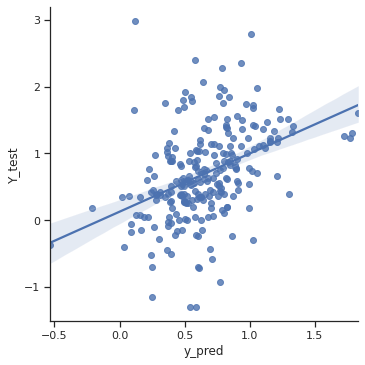

4
(995, 513)
(248, 513)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
Calculating Permutation Importances
248
2-fold :  50.0
3-fold :  72.58064516129032
5-fold :  85.08064516129032
gmfe :  2.391410822944391
mfe :  1.3516348399657296
bias :  0.5172649687111045
rmse  0.5066084600453384
r2  0.3026080591193375


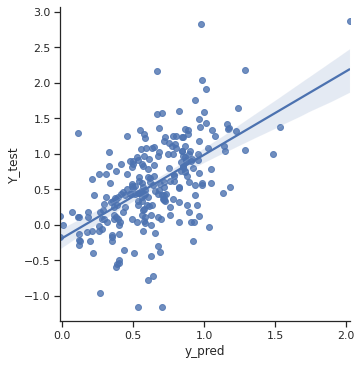

human_thalf
0
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
253
2-fold :  44.26877470355731
3-fold :  68.37944664031622
5-fold :  86.16600790513834
gmfe :  2.550746836697727
mfe :  1.404535080186314
bias :  -0.09600037321459154
rmse  0.526531027695118
r2  0.29625813328224715
saving model


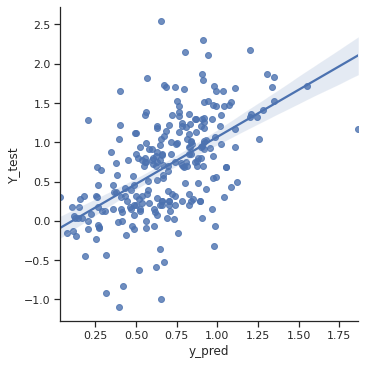

1
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
253
2-fold :  52.569169960474305
3-fold :  69.1699604743083
5-fold :  85.37549407114624
gmfe :  2.4494433832368196
mfe :  1.3395859338516038
bias :  0.3515962874910614
rmse  0.5227831429221543
r2  0.2928442506481499
saving model


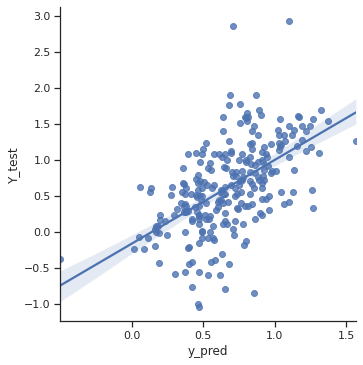

2
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=42)
Calculating Permutation Importances
253
2-fold :  52.96442687747036
3-fold :  74.30830039525692
5-fold :  86.16600790513834
gmfe :  2.317502822446769
mfe :  1.3177750284603524
bias :  0.0722320693963523
rmse  0.4877145191343243
r2  0.30111735241122706
saving model


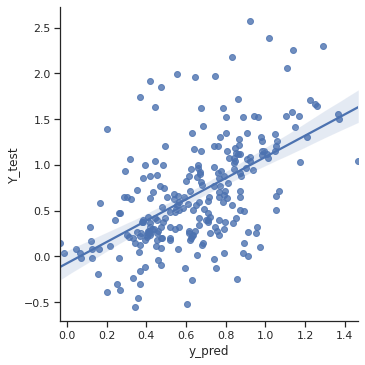

3
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
Calculating Permutation Importances
253
2-fold :  49.01185770750988
3-fold :  68.37944664031622
5-fold :  82.21343873517787
gmfe :  2.7139798131879873
mfe :  1.35871998787002
bias :  0.2741606293388754
rmse  0.5981670289139279
r2  0.2683837338475039


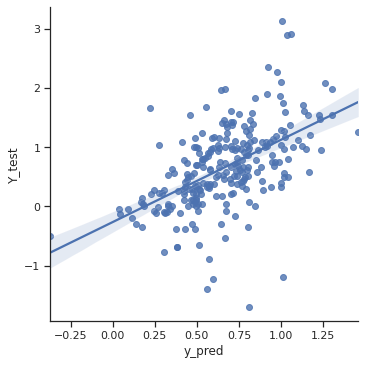

4
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=42)
Calculating Permutation Importances
253
2-fold :  53.75494071146245
3-fold :  76.6798418972332
5-fold :  89.72332015810277
gmfe :  2.190744050560291
mfe :  1.3218866676900747
bias :  0.2724892663843388
rmse  0.4599537146923928
r2  0.35450059533477807
saving model


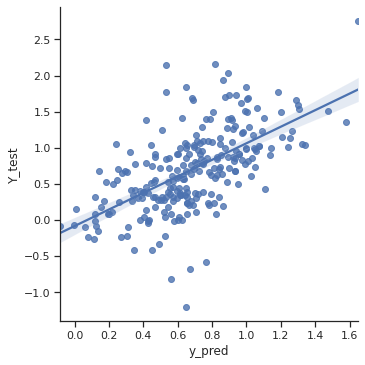

0
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=43)
Calculating Permutation Importances
253
2-fold :  47.03557312252965
3-fold :  72.33201581027669
5-fold :  89.72332015810277
gmfe :  2.283672681710899
mfe :  1.3736405206307767
bias :  -0.017644088625931698
rmse  0.46243632771548043
r2  0.3277653516623833


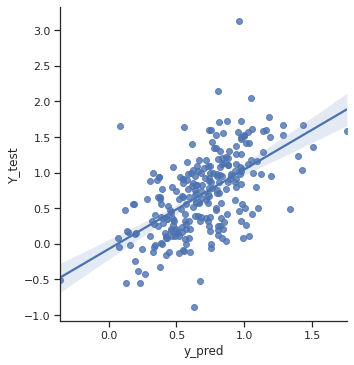

1
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
Calculating Permutation Importances
253
2-fold :  51.38339920948617
3-fold :  69.1699604743083
5-fold :  81.81818181818183
gmfe :  2.576754994517995
mfe :  1.3399046427107921
bias :  0.5275272360364789
rmse  0.5682563185498867
r2  0.274067403913974


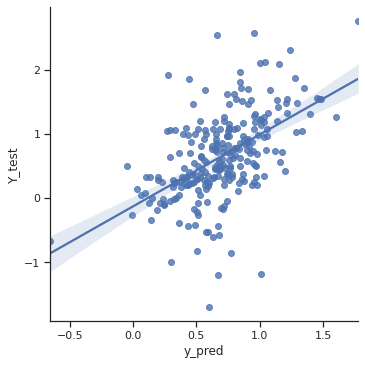

2
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
Calculating Permutation Importances
253
2-fold :  52.569169960474305
3-fold :  68.77470355731225
5-fold :  87.35177865612648
gmfe :  2.477673047010652
mfe :  1.3338299824592785
bias :  0.11461944120287759
rmse  0.5262027032853763
r2  0.24994072417126012


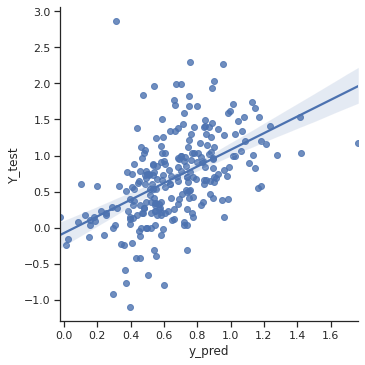

3
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
Calculating Permutation Importances
253
2-fold :  49.40711462450593
3-fold :  70.7509881422925
5-fold :  83.79446640316206
gmfe :  2.4327375460556113
mfe :  1.3614818187033024
bias :  0.01671384268546605
rmse  0.5133989122657836
r2  0.31225735485862616


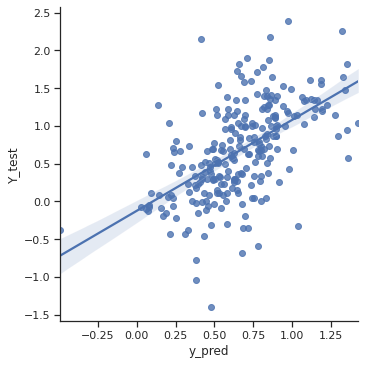

4
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
Calculating Permutation Importances
253
2-fold :  53.359683794466406
3-fold :  73.91304347826086
5-fold :  84.98023715415019
gmfe :  2.375058004572995
mfe :  1.3073687805699827
bias :  0.26602335656060716
rmse  0.5192474349196092
r2  0.36334418690871606


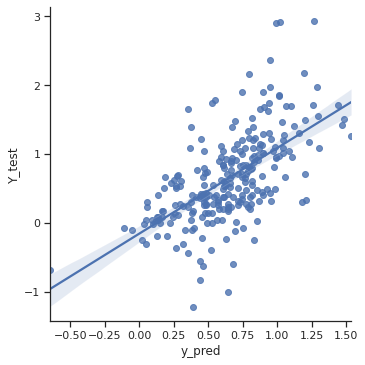

0
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
253
2-fold :  53.75494071146245
3-fold :  77.07509881422925
5-fold :  89.32806324110672
gmfe :  2.2249935067754505
mfe :  1.3227280097815863
bias :  0.13229983494198105
rmse  0.4606255159736022
r2  0.34434219708804603


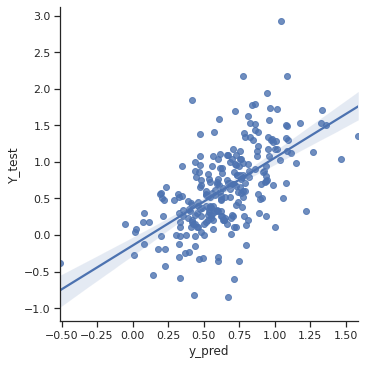

1
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
Calculating Permutation Importances
253
2-fold :  47.03557312252965
3-fold :  70.35573122529645
5-fold :  84.98023715415019
gmfe :  2.537871801291981
mfe :  1.3780224636453668
bias :  0.23928252919591841
rmse  0.5386437581463994
r2  0.3101679153301774


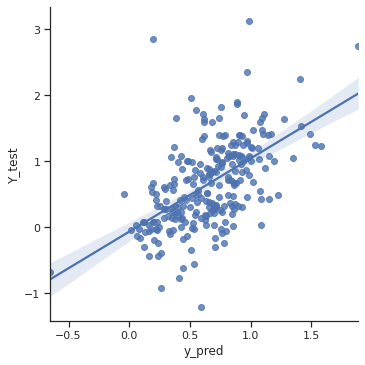

2
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
253
2-fold :  52.569169960474305
3-fold :  70.7509881422925
5-fold :  89.32806324110672
gmfe :  2.3602654111921386
mfe :  1.3300759933419326
bias :  0.3600248177641747
rmse  0.49740439074537135
r2  0.31196682951575094


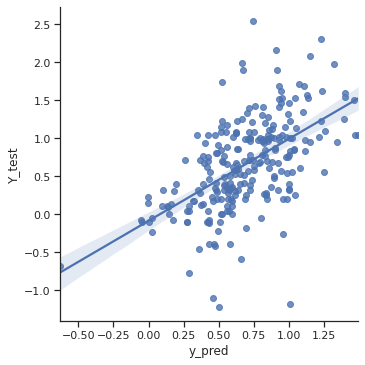

3
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
Calculating Permutation Importances
253
2-fold :  47.03557312252965
3-fold :  67.19367588932806
5-fold :  83.00395256916995
gmfe :  2.6218505102706064
mfe :  1.3689106616943383
bias :  0.4911682063463312
rmse  0.5631108835629736
r2  0.27213192328078173


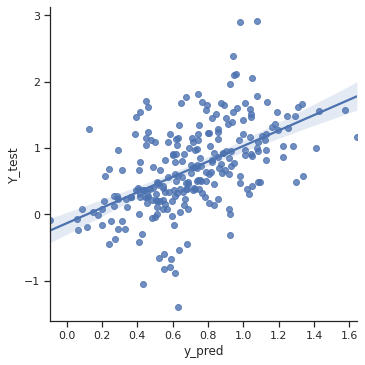

4
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=44)
Calculating Permutation Importances
253
2-fold :  48.616600790513836
3-fold :  71.54150197628458
5-fold :  84.98023715415019
gmfe :  2.4773318874656103
mfe :  1.36497217075588
bias :  0.03137280469544823
rmse  0.5436005355952055
r2  0.25724680990848436


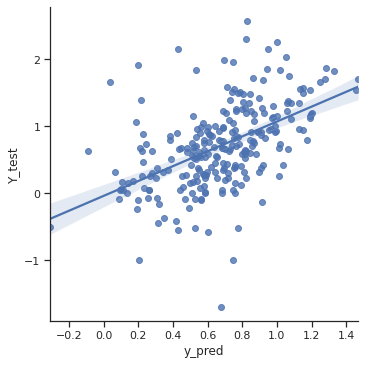

0
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
253
2-fold :  46.6403162055336
3-fold :  70.7509881422925
5-fold :  85.37549407114624
gmfe :  2.515309814016786
mfe :  1.3650118695464097
bias :  0.40697117430951213
rmse  0.5340626427456311
r2  0.27002542411206454


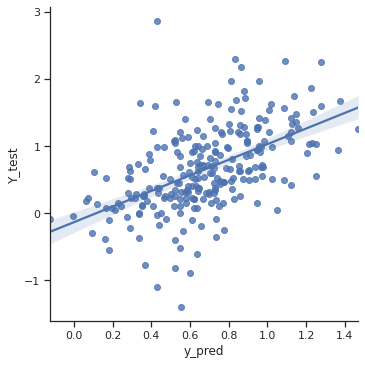

1
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
253
2-fold :  50.19762845849802
3-fold :  71.93675889328063
5-fold :  89.32806324110672
gmfe :  2.327325423764843
mfe :  1.3430008342963562
bias :  0.2275857543552786
rmse  0.474615994303772
r2  0.30869560960885456


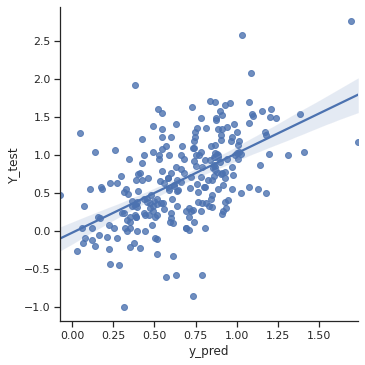

2
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
253
2-fold :  51.77865612648221
3-fold :  72.33201581027669
5-fold :  85.37549407114624
gmfe :  2.469491197807941
mfe :  1.3375918394492008
bias :  -0.1738390834141903
rmse  0.5501635904072223
r2  0.2687007393243296


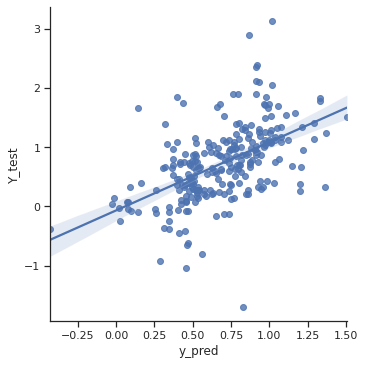

3
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
253
2-fold :  50.988142292490124
3-fold :  70.7509881422925
5-fold :  82.6086956521739
gmfe :  2.5334969330347095
mfe :  1.3476228526816199
bias :  0.4199056407818667
rmse  0.541627156620368
r2  0.30192969982888307


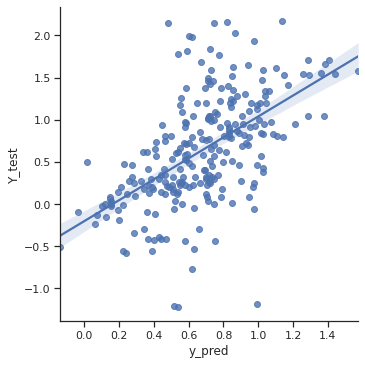

4
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=45)
Calculating Permutation Importances
253
2-fold :  50.988142292490124
3-fold :  71.14624505928853
5-fold :  87.74703557312253
gmfe :  2.380948290875438
mfe :  1.3418506558138106
bias :  0.1725133754067263
rmse  0.5055162563694147
r2  0.3380587148119699


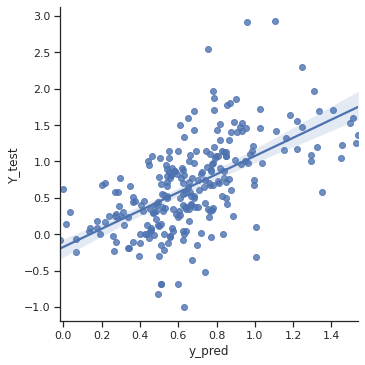

0
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
253
2-fold :  46.24505928853755
3-fold :  67.19367588932806
5-fold :  83.79446640316206
gmfe :  2.6199964159728863
mfe :  1.4136100713429225
bias :  -0.20292022846152835
rmse  0.5547802737029347
r2  0.19204833059810467


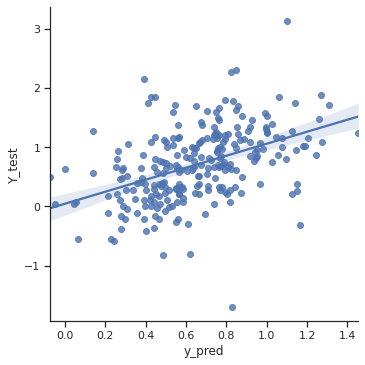

1
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
253
2-fold :  51.77865612648221
3-fold :  77.07509881422925
5-fold :  88.53754940711462
gmfe :  2.2236647850431632
mfe :  1.3362005163820165
bias :  0.2295061694105156
rmse  0.46060012876305756
r2  0.34101335802217125


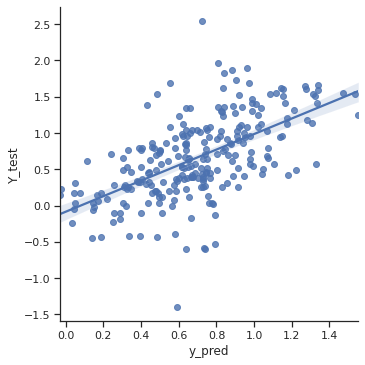

2
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
253
2-fold :  52.569169960474305
3-fold :  72.33201581027669
5-fold :  84.98023715415019
gmfe :  2.3703938220982277
mfe :  1.3247648332541135
bias :  0.16617414380841922
rmse  0.5069660604440466
r2  0.2999459081645486


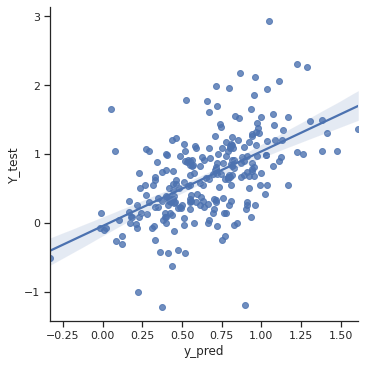

3
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=46)
Calculating Permutation Importances
253
2-fold :  49.01185770750988
3-fold :  69.56521739130434
5-fold :  83.79446640316206
gmfe :  2.5781799616810694
mfe :  1.3608756255960222
bias :  0.47802612622827945
rmse  0.5511321408851109
r2  0.3462339884502882


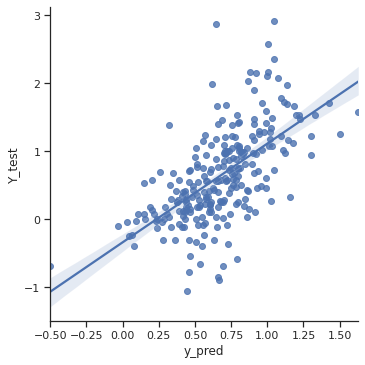

4
(1012, 513)
(253, 513)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
Calculating Permutation Importances
253
2-fold :  50.59288537549407
3-fold :  71.54150197628458
5-fold :  87.35177865612648
gmfe :  2.4200169040282544
mfe :  1.3406740676437237
bias :  0.07313527092766936
rmse  0.5179733977524146
r2  0.33610124858394186


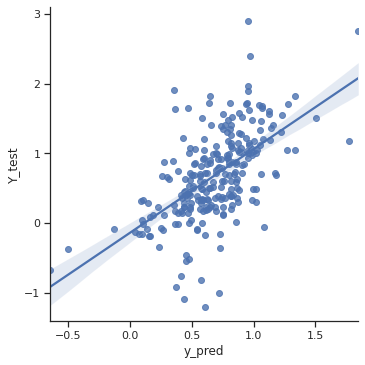

In [23]:
from sklearn.preprocessing import StandardScaler
import pickle
list_of_lists=[]
detail_list_batch=[]
model_parameters_batch=[]


for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg", "human_fup", "human_mrt", "human_thalf"]:

    data = human_lombardo_mfp_Mordred_animal
    features = features_mfp_mordred_animal_columns
    baseline=10.00

    print(endpoint)    
    df = data.dropna(subset=[endpoint]).reset_index(drop=True)

    X = df[features]
    Y = df[endpoint]
    
    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X, columns=features)
    
    #Nested Cross Validation    
    for i in range(42, 47):
        
        outercv = KFold(n_splits=5, random_state=i, shuffle=True) 

        for split, (train_index, test_index) in enumerate(outercv.split(X)):
            
            print(split)
            train = df.iloc[train_index]
            X_train= X.iloc[train_index].values
            Y_train= Y.iloc[train_index].values.flatten()

            test = df.iloc[test_index]
            X_test= X.iloc[test_index].values
            Y_test= Y.iloc[test_index].values.flatten()

            print(X_train.shape)
            print(X_test.shape)

            inner_cv = KFold(n_splits=4, random_state=i, shuffle=True) 

            # Create a based model
            regressor = RandomForestRegressor(random_state = i, n_jobs=20)

            # Instantiate the RandomHalving search model
            param_grid = { 
            "n_estimators": [100,200,300],
            "max_features": ["sqrt", "log2"],
            "min_samples_split": [2,4,8],
            "max_depth": [5, 10, 15],    
            "bootstrap": [True, False],
            'n_jobs': [30]
            }

            gsh = GridSearchCV(estimator = regressor, param_grid = param_grid, cv = inner_cv, n_jobs=30, verbose = 1)

            ##MODELS
            print(f"Running ____________________{endpoint} MODELS")

            gsh.fit(X_train, Y_train)
            #print(gsh.best_estimator_)

            #HeldOutTest
            classifier = gsh.best_estimator_
            print(classifier)
            
            row=[endpoint, i, split, classifier.n_estimators, classifier.max_features,
                classifier.min_samples_split, classifier.max_depth, classifier.bootstrap]
            model_parameters_batch.append(row)
            
            
            classifier.fit(X_train, Y_train)

            print("Calculating Permutation Importances")  
            y_pred =  classifier.predict(X_test)     
            print(len(y_pred))

            fold_2= count(y_pred, Y_test, 0.5, 2, endpoint)
            fold_3= count(y_pred, Y_test, 1/3, 3, endpoint)
            fold_5= count(y_pred, Y_test, 1/5, 5, endpoint)
            gmfe = calc_gmfe(y_pred, Y_test, endpoint)
            mfe = median_fold_change_error(y_pred, Y_test, endpoint)
            bias = calc_bias(y_pred, Y_test, endpoint)

            print("2-fold : ", fold_2)
            print("3-fold : ", fold_3)
            print("5-fold : ", fold_5)
            print("gmfe : ", gmfe)
            print("mfe : ", mfe)
            print("bias : ", bias)

            rmse = sqrt(mean_squared_error(Y_test, y_pred))
            print('rmse ',rmse)
            r2 = r2_score(Y_test, y_pred)
            print('r2 ',r2)

            if (gmfe<baseline):
                # save
                print("saving model")
                baseline=gmfe
                pickle.dump(classifier, open(f"log_{endpoint}_withanimaldata_real_and_artificial_model.sav",  'wb'))

            sns.set_theme(style="ticks")
            df_plot=pd.DataFrame({"y_pred":y_pred, "Y_test":Y_test})
            sns.lmplot(data=df_plot, x="y_pred", y="Y_test")
            plt.show()

            row=["HeldOut",  endpoint, i, split, fold_2, fold_3, fold_5, gmfe, mfe, bias, rmse, r2]
            list_of_lists.append(row)
            
            #combine results
            for smiles_r, pred, true in zip(test.smiles_r, y_pred, Y_test):
                detail_list_batch.append([endpoint, i, split, smiles_r, pred, true])


In [24]:
model_parameters= pd.DataFrame(model_parameters_batch,columns=["endpoint", "random_state", 
                                                            "split", "n_estimators", "max_features",
                "min_samples_split", "max_depth", "bootstrap"])
model_parameters

endpoint  random_state  split  n_estimators max_features  \
0    human_VDss_L_kg            42      0           100         sqrt   
1    human_VDss_L_kg            42      1           200         sqrt   
2    human_VDss_L_kg            42      2           300         sqrt   
3    human_VDss_L_kg            42      3           300         sqrt   
4    human_VDss_L_kg            42      4           100         sqrt   
..               ...           ...    ...           ...          ...   
120      human_thalf            46      0           300         sqrt   
121      human_thalf            46      1           300         sqrt   
122      human_thalf            46      2           300         sqrt   
123      human_thalf            46      3           200         sqrt   
124      human_thalf            46      4           300         sqrt   

     min_samples_split  max_depth  bootstrap  
0                    4         15      False  
1                    2         15      False  
2                    2         15      False  
3                    2         15      False  
4                    8         15      False  
..                 ...        ...        ...  
120                  2         15      False  
121                  2         15      False  
122                  4         15      False  
123                  8         15      False  
124                  2         15      False  

[125 rows x 8 columns]

In [25]:
detail_list = pd.DataFrame(detail_list_batch,columns=["endpoint", "random_state", 
                                                           "split", "smiles_r", "pred", "true"])
detail_list["key"] =  detail_list["endpoint"].astype(str) + detail_list["smiles_r"].astype(str) + detail_list["random_state"].astype(str)+ detail_list["split"].astype(str)
detail_list

endpoint  random_state  split  \
0      human_VDss_L_kg            42      0   
1      human_VDss_L_kg            42      0   
2      human_VDss_L_kg            42      0   
3      human_VDss_L_kg            42      0   
4      human_VDss_L_kg            42      0   
...                ...           ...    ...   
29580      human_thalf            46      4   
29581      human_thalf            46      4   
29582      human_thalf            46      4   
29583      human_thalf            46      4   
29584      human_thalf            46      4   

                                                smiles_r      pred      true  \
0      C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc([O-])ccc4[C@H...  0.262672  0.633468   
1      C=C(CC(NC(=O)c1ccc(CCc2cnc3nc(N)nc(N)c3n2)cc1)... -0.081631 -0.154902   
2      C=CC1=C(C(=O)[O-])[NH+]2C(=O)C(=NC(=O)C(NOCC(=... -0.684350 -0.619789   
3                         C=CCc1ccccc1OCC(O)C[NH2+]C(C)C  0.345670  0.505150   
4      C=C[C@@H]1C[C@]1(NC(=O)C1C[C@@H](Oc2ncc(OC)c3c...  0.011148  0.442480   
...                                                  ...       ...       ...   
29580  [NH3+]CCCCC(NC(=O)C(Cc1cc(Br)c([O-])c(Br)c1)NC...  0.830554  0.397940   
29581                 [NH3+]C[C@H]1OB(O)c2c(OCCCO)cccc21  0.526135  1.064458   
29582                [O-]c1ccc(C2=Cc3ccc([O-])cc3OC2)cc1  0.605440 -0.173925   
29583  [O-]c1ccc([C@H]2C[NH2+]CCc3c2cc([O-])c([O-])c3...  0.579812  0.000000   
29584                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1  0.865664  0.359835   

                                                     key  
0      human_VDss_L_kgC#C[C@]1(O)CC[C@H]2[C@@H]3CCc4c...  
1      human_VDss_L_kgC=C(CC(NC(=O)c1ccc(CCc2cnc3nc(N...  
2      human_VDss_L_kgC=CC1=C(C(=O)[O-])[NH+]2C(=O)C(...  
3       human_VDss_L_kgC=CCc1ccccc1OCC(O)C[NH2+]C(C)C420  
4      human_VDss_L_kgC=C[C@@H]1C[C@]1(NC(=O)C1C[C@@H...  
...                                                  ...  
29580  human_thalf[NH3+]CCCCC(NC(=O)C(Cc1cc(Br)c([O-]...  
29581   human_thalf[NH3+]C[C@H]1OB(O)c2c(OCCCO)cccc21464  
29582  human_thalf[O-]c1ccc(C2=Cc3ccc([O-])cc3OC2)cc1464  
29583  human_thalf[O-]c1ccc([C@H]2C[NH2+]CCc3c2cc([O-...  
29584  human_thalfc1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1464  

[29585 rows x 7 columns]

In [26]:
results = pd.DataFrame(list_of_lists, columns=["HeldOut", "endpoint", "random_state", "split", "fold_2", "fold_3", "fold_5", "gmfe", "mfe", "bias", "rmse", "r2"])
results

HeldOut         endpoint  random_state  split     fold_2     fold_3  \
0    HeldOut  human_VDss_L_kg            42      0  56.800000  74.400000   
1    HeldOut  human_VDss_L_kg            42      1  58.400000  75.600000   
2    HeldOut  human_VDss_L_kg            42      2  57.200000  73.600000   
3    HeldOut  human_VDss_L_kg            42      3  60.400000  74.800000   
4    HeldOut  human_VDss_L_kg            42      4  53.815261  74.297189   
..       ...              ...           ...    ...        ...        ...   
120  HeldOut      human_thalf            46      0  46.245059  67.193676   
121  HeldOut      human_thalf            46      1  51.778656  77.075099   
122  HeldOut      human_thalf            46      2  52.569170  72.332016   
123  HeldOut      human_thalf            46      3  49.011858  69.565217   
124  HeldOut      human_thalf            46      4  50.592885  71.541502   

        fold_5      gmfe       mfe      bias      rmse        r2  
0    87.600000  2.147837  1.304531  0.045423  0.443150  0.544851  
1    90.000000  2.069260  1.288237  0.105554  0.409983  0.549781  
2    86.400000  2.205408  1.265574 -0.002962  0.475786  0.478857  
3    89.600000  2.077875  1.281588 -0.001214  0.419641  0.579518  
4    90.763052  2.185058  1.316643  0.050475  0.445395  0.485837  
..         ...       ...       ...       ...       ...       ...  
120  83.794466  2.619996  1.413610 -0.202920  0.554780  0.192048  
121  88.537549  2.223665  1.336201  0.229506  0.460600  0.341013  
122  84.980237  2.370394  1.324765  0.166174  0.506966  0.299946  
123  83.794466  2.578180  1.360876  0.478026  0.551132  0.346234  
124  87.351779  2.420017  1.340674  0.073135  0.517973  0.336101  

[125 rows x 12 columns]

In [27]:
model_parameters.to_csv("model_parameters_Prediction_human_from_mordred_morgan_fs_animal_artificial_and_real.csv", index=False)

In [28]:
detail_list.to_csv("detail_list_Prediction_human_from_mordred_morgan_fs_animal_artificial_and_real.csv", index=False)

In [29]:
results.to_csv("Prediction_human_from_mordred_morgan_fs_animal_artificial_and_real.csv", index=False)

In [30]:
import pandas as pd
results= pd.read_csv("Prediction_human_from_mordred_morgan_fs_animal_artificial_and_real.csv")
results.groupby("endpoint").mean().reset_index().to_csv("human_with_mfp_mordred_animal_artificial_and_real.csv", index=False)
results.groupby("endpoint").mean()

random_state  split     fold_2     fold_3     fold_5  \
endpoint                                                                   
human_CL_mL_min_kg          44.0    2.0  50.803928  70.132478  84.667680   
human_VDss_L_kg             44.0    2.0  57.469815  75.292980  89.336739   
human_fup                   44.0    2.0  55.426883  67.417143  78.247792   
human_mrt                   44.0    2.0  49.702682  70.731766  83.329835   
human_thalf                 44.0    2.0  50.245059  71.335968  85.913043   

                        gmfe       mfe      bias      rmse        r2  
endpoint                                                              
human_CL_mL_min_kg  2.483780  1.342918 -0.262728  0.539961  0.302952  
human_VDss_L_kg     2.129475  1.286928  0.030622  0.437055  0.531298  
human_fup           2.763755  1.286188  0.038702  0.212352  0.607478  
human_mrt           2.516332  1.355981  0.038765  0.544227  0.275227  
human_thalf         2.441178  1.349386  0.193317  0.519421  0.301564

In [31]:
import pickle
# load
loaded_rf = pickle.load(open("log_human_VDss_L_kg_withanimaldata_real_and_artificial_model.sav", 'rb'))

In [32]:
loaded_rf

RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)